In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
import numpy as np
import scipy as sp
import h5py
from scipy.interpolate import interp1d
from scipy.linalg import sqrtm, solve_sylvester, solve_lyapunov, expm
from scipy.io import loadmat
import matplotlib.pyplot as plt
import sys
import flowField
import impulseResponse as impres
import pseudo
import os
import glob
import time
import miscUtil
import ops
%matplotlib inline
#%matplotlib notebook

saveFolder= '/kepler/sabarish/impulseResponse/jovanovic/'
figureFolder = 'jovanovicThesis/'

# Definitions

## Dynamical system
For a particular Fourier mode identified by $(\alpha,\beta)$, the dynamical system is characterized by constant matrices $A,B,C$ as
$$ \dot{{\psi}}(y,t) = A(y) {\psi}(y,t) + B(y) {d}(y,t)$$

$$ \phi(y,t) = C(y){\psi}(y,t)$$
where $\phi = [u, v, w]^T$, ${\psi} = [v, \omega_y]^T$
These differ from the notation of CoT, where $\phi$ is the velocity-vorticity, and $\psi$ is a transformation of $\phi$. 

$A, B$ are defined in Eq. 7.8 (with hats) of the thesis. $C$ is defined in Eq. 7.17. 

A structured forcing is also defined, where the white-like noise with identity-like covariance, $d$, is weighted by $y$-dependent factors $\gamma_s, s \in \{x,y,z\}$. This is introduced by defining 
$$ B_0 = B\begin{bmatrix} \gamma_x &0 &0 \\ 0&\gamma_y&0 \\ 0&0&\gamma_z \end{bmatrix},$$ 
and $B_0$ replaces $B$ in the system equation (Eq. 7.19, 7.20 in thesis). 

When studying impulse response, the white noise $d$ is replaced by an impulse (in time), $\delta(t) $, with some spiky wall-normal distribution, $f_s(y)$, along the $s$-coordinate in the LNSE. In the state equation, this impulse is written as
$$ \dot{{\psi}}(y,t) = A(y) {\psi}(y,t) + F(y)\delta(t)$$
where
$$ F(y) = B \begin{bmatrix} f_x(y) \\ f_y(y) \\ f_z(y) \end{bmatrix}$$
and $\delta(t)$ is the Dirac-delta function which is non-zero at only $t=0$. 

## Norms and adjoints

Three dot products are in use: The energy product, $<.,.>_e$, the $L^2\lbrack-1,1\rbrack$ product on the bounded wall-normal domain, $<.,.>$, and the Euclidean dot product, $<.,.>_\mathbb{C}$.

The matrix $\mathcal{Q}$,
$$ \mathcal{Q} = \frac{1}{\alpha^2 + \beta^2}\begin{bmatrix} 
                -\Delta & 0 \\ 0 & I 
                \end{bmatrix}, \Delta = D^2 - (\alpha^2 + \beta^2)I, $$
is defined so that the energy in a Fourier mode is given as
$$ E = \big< \psi, \psi \big>_e = 
    \frac{1}{8} \int_{-1}^1 \psi^* \mathcal{Q} \psi dy =
    \big< \psi, \mathcal{Q} \psi \big>$$
This is a bit funny because I can show that using the matrix $\mathcal{Q}$ above doesn't actually give the energy, $u^2 + v^2 + w^2$, as mentioned above. Jovanovic refers to Butler and Farrell 1993, but doesn't actually derive the matrix. That's a problem; but, I'll stick to it for now. 

The energy is the appropriate measure for measuring gains.     

The adjoints, $A^*, B^*, C^*$ are defined in Eq. 7.27-29, and the adjoint of the impulse forcing characterized by $F$


## Fig. 8.1.1 Plots of $||H_{rs}||_2(kx,kz)$ in Poiseuille flow with $Re = 2000$.

Here, $H_{rs}$ represents the response in the $r^{th}$ velocity component due to forcing in the $s^{th}$ direction (for zero initial state),
$$ u_r(y,t) = H_{rs}(y,t) d_s(y,t).$$

The norm, $||H||_2$, is the integral over all times (or frequencies) of the energy in the forced system. It can be computed by first solving the Lyapunov equation,
$$ AX + XA^* = -BB^*,$$
where, it is assumed that the forcing $d$ has identity covariance. The $||H||_2$ norm is then given by 
$$ ||H||_2  = tr(X)$$
(See sec. 2.2.2 of the thesis). The big question here is, are the matrices $A$ and $A^*$ in the above equation the original ones, or do they involve $\mathcal{Q}$? They must involve Q. 

The question is, how do I compute each $||H_{rs}||_2$? The $s$ components are easy to handle: Just use $BWB^*$ in the Lyapunov equation with a diagonal $W$ with $2N$ diagonal entries set to zero. For $r$ components, I'll do this: compute $X$ as usual, and then compute $\Phi$ as in the CoT paper to get covariances of velocity components. Then, the trace of each of the three diagonal blocks gives one $r$ component. 

In [153]:
# Initialization
Re = 2000.       
# Grid
N = 40   # Wall-normal
aArr = 10.**np.linspace(-4., 0.5, 20)
bArr = 10**np.linspace(-2., 1.5, 35)
#aArr = np.array([1.])
#bArr = np.array([0., 1.])
#wArr = 10**np.linspace(-3., 0.5, 44)
#aArr = np.concatenate((-aArr[::-1], [0.],aArr))
#wArr = np.concatenate((-wArr[::-1], [0.],wArr))


# H_{rs} has 9 components, so let's define a 3x3 matrix for each a,b,omega,
amplArr = np.zeros((aArr.size, bArr.size, 3,3))
# Forcing covariance (Ws) for each $s$ component:
Ws = np.zeros((3,3*N,3*N),dtype=np.complex)
Ws[0,  :N ,:N   ] = np.identity(N) 
Ws[1,N:2*N,N:2*N] = np.identity(N)
Ws[2,2*N: ,2*N: ] = np.identity(N)

y, DM = pseudo.chebdif(N,2)
D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]
Umat   = np.diag(1. - y**2)
dUmat  = np.diag(-2.*y)
d2Umat = -2.*np.identity(N)
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']

for i0 in range(aArr.size):
    statInst.a = aArr[i0]
    a = aArr[i0]
    for i1 in range(bArr.size):
        statInst.b = bArr[i1]
        b = bArr[i1]
        if (statInst.a == 0.) and (statInst.b==0.):
            continue
        #A,C,B = statInst.makeSystemNew()
        Delta = D2 - (a**2 + b**2) * I1
        DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
        DeltaInv = np.linalg.solve(Delta, I1)
        
        Q = 1./(a**2+b**2)* np.identity(2*N,dtype=np.complex)
        Q[:N,:N] = - Delta/(a**2+b**2)
        
        
        Qsqrt = W2s @ sqrtm(Q)
        QsqrtInv = np.linalg.solve(Qsqrt,I2)
        
        LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
        LSQ = -1.j*a*Umat + Delta/Re
        Lco = -1.j*b*dUmat
        k2 = a**2 + b**2
        A = np.vstack(( 
                np.hstack(( DeltaInv @ LOS, Z1 )),
                np.hstack(( Lco           , LSQ)) ))
        LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
        Lcoadj = -1.j*b*DeltaInv @ dUmat
        LSQadj = 1.j*a*Umat + Delta/Re
        Aadj = np.vstack((
                np.hstack(( LOSadj, Lcoadj)),
                np.hstack(( Z1    , LSQadj))  ))
        B = np.vstack((
                DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
                np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
        C = (1./k2) * np.vstack((
                np.hstack((1.j*a*D1, -1.j*b*I1)),
                np.hstack((k2 * I1 , Z1       )),
                np.hstack((1.j*b*D1,  1.j*a*I1)) ))
        #Apsi = Qsqrt @ A @ QsqrtInv
        #Bpsi = Qsqrt @ B @ W3si
        #Cpsi = W3s @ C @ QsqrtInv
        Badj = C; Cadj = B
        for i3 in range(3):
            #X = solve_lyapunov( A, -np.identity(2*N) )
            #X = solve_lyapunov( Apsi, -Bpsi @ Ws[i3] @ Bpsi.conj().T )
            X = solve_sylvester( A, Aadj, -B @ Ws[i3] @ Badj )
            Phi = C @ X @ Cadj
            
            amplArr[i0,i1,0,i3]  = np.trace(Phi[:N   ,:N   ].real)
            amplArr[i0,i1,1,i3]  = np.trace(Phi[N:2*N,N:2*N].real)
            amplArr[i0,i1,2,i3]  = np.trace(Phi[2*N: ,2*N: ].real)

In [154]:
amplArr2 = amplArr.copy()

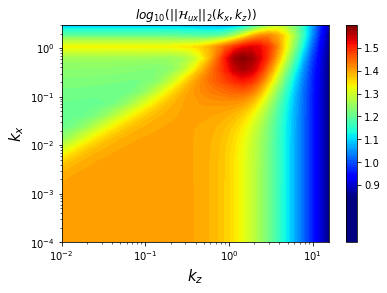

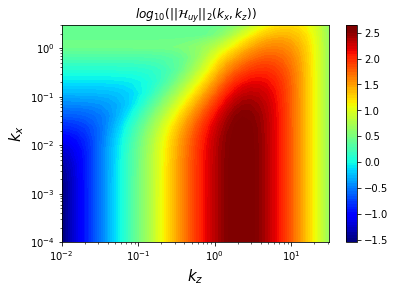

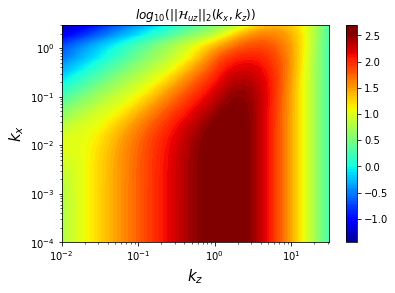

In [160]:
amplArr = np.sqrt(amplArr2)
plt.contourf(bArr, aArr, np.log10(amplArr[:,:,0,0]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([0.85,1.6])
plt.colorbar(ticks=np.arange(0.9,1.55,0.1))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{ux}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p1aa.eps',format='eps')
plt.show()


plt.contourf(bArr, aArr, np.log10(amplArr[:,:,0,1]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.ylim([1.e-4, 3.02])
plt.clim([0.85,1.6])
plt.clim([-1.5,2.55])
plt.colorbar(ticks=np.arange(-1.5,2.6,0.5))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{uy}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p1ab.eps',format='eps')
plt.show()

plt.contourf(bArr, aArr, np.log10(amplArr[:,:,0,2]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.ylim([1.e-4, 3.02])
plt.clim([0.85,1.6])
plt.clim([-1.5,2.55])
plt.colorbar(ticks=np.arange(-1.,2.6,0.5))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{uz}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p1ac.eps',format='eps')
plt.show()

Are you kidding me? All that talk about using a proper norm, and then it's not used at all? 

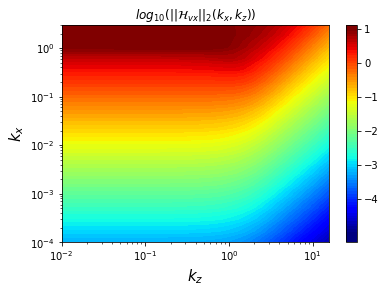

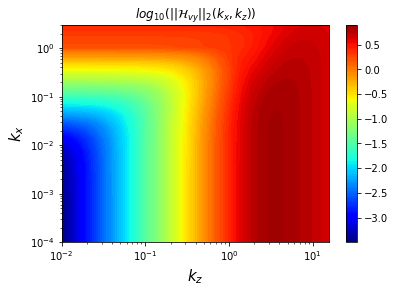

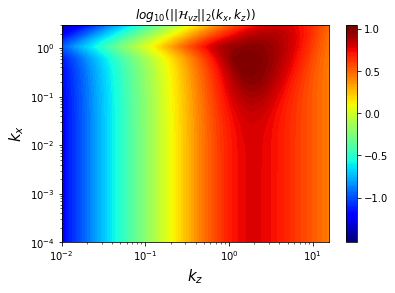

In [161]:
plt.contourf(bArr, aArr, np.log10(amplArr[:,:,1,0]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([-5.,1.])
plt.colorbar(ticks=np.arange(-4.,1.1,1.))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{vx}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p1ba.eps',format='eps')
plt.show()


plt.contourf(bArr, aArr, np.log10(amplArr[:,:,1,1]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([-3.5,1.])
plt.colorbar(ticks=np.arange(-3.,0.6,0.5))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{vy}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p1bb.eps',format='eps')
plt.show()

plt.contourf(bArr, aArr, np.log10(amplArr[:,:,1,2]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([-1.5,1.])
plt.colorbar(ticks=np.arange(-1.,1.1,0.5))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{vz}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p1bc.eps',format='eps')
plt.show()

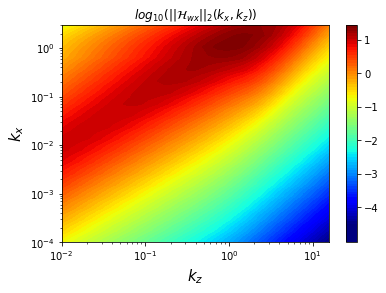

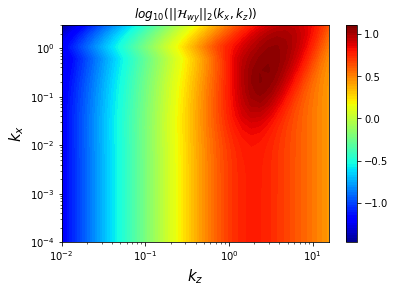

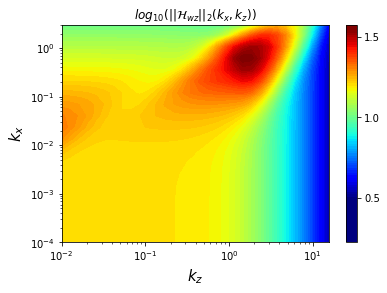

In [162]:
plt.contourf(bArr, aArr, np.log10(amplArr[:,:,2,0]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([-4.5,1.4])
plt.colorbar(ticks=np.arange(-4.,1.5,1.))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{wx}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p1ca.eps',format='eps')
plt.show()


plt.contourf(bArr, aArr, np.log10(amplArr[:,:,2,1]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([-1.5,1.1])
plt.colorbar(ticks=np.arange(-1.,1.05,0.5))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{wy}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p1cb.eps',format='eps')
plt.show()

plt.contourf(bArr, aArr, np.log10(amplArr[:,:,2,2]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([0.5,1.55])
plt.colorbar(ticks=np.arange(0.5,1.55,0.5))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{wz}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p1cc.eps',format='eps')
plt.show()

## Fig. 8.6: Frequency response


In [ ]:
# Initialization
Re = 2000.       
# Grid
N = 30   # Wall-normal
aArr = 10.**np.linspace(-4., 0.5, 25)
bArr = 10**np.linspace(-2., 1.5, 45)
#aArr = np.array([1.])
#bArr = np.array([0., 1.])
#wArr = 10**np.linspace(-3., 0.5, 44)
aArr = np.concatenate((-aArr[::-1], [0.],aArr))
wArr = np.concatenate((-wArr[::-1], [0.],wArr))

# Re argument to statComp just tells it what $U$ to use for non-dimensionalization
# As long as I use the correct base velocity profile, Re choice is fine.
statInst = ops.statComp(N=N,Re=Re,a=aArr[0], b=bArr[0],covMat=np.identity(3*N))
statInst.U = 1.- statInst.y**2
statInst.dU= -2.*statInst.y
statInst.d2U = -2.*np.ones(N)
statInst.nu = np.ones(N)


## Fig. 8.7 Singular values

Using parameters Re=2000, alfa=25.4, kapa=0.426, N=70
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


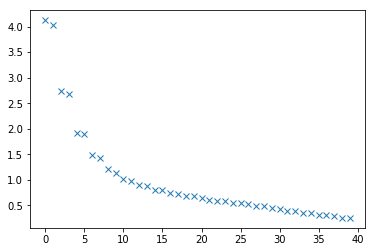

In [89]:
N = 70; a = 0.; b = 1.62; omega = 0.; Re=2000.
statInst = ops.statComp(N=N,Re=Re,a=a, b=b,covMat=np.identity(3*N))
statInst.U = 1.- statInst.y**2
statInst.dU= -2.*statInst.y
statInst.d2U = -2.*np.ones(N)
statInst.nu = np.ones(N)

y, DM = pseudo.chebdif(N,2)
D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]
Umat   = np.diag(1. - y**2)
dUmat  = np.diag(-2.*y)
d2Umat = -2.*np.identity(N)
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))

Delta = D2 - (a**2 + b**2) * I1
DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
DeltaInv = np.linalg.solve(Delta, I1)

LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
LSQ = -1.j*a*Umat + Delta/Re
Lco = -1.j*b*dUmat
k2 = a**2 + b**2
A = np.vstack(( 
        np.hstack(( DeltaInv @ LOS, Z1 )),
        np.hstack(( Lco           , LSQ)) ))
B = np.vstack((
        DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
        np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
C = (1./k2) * np.vstack((
        np.hstack((1.j*a*D1, -1.j*b*I1)),
        np.hstack((k2 * I1 , Z1       )),
        np.hstack((1.j*b*D1,  1.j*a*I1)) ))

res = ( 1.j*omega*I2 - A); resInv = np.linalg.solve(res,I2)
H = C @ resInv @ B
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']

Hw = W3s @ H @ W3si
svals = np.linalg.svd(Hw)[1]
plt.plot(np.log10(svals[:40]),'x')

plt.show()


Using parameters Re=2000, alfa=25.4, kapa=0.426, N=70
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


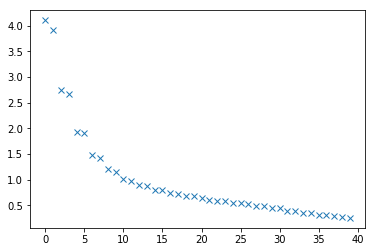

In [88]:
N = 70; a = 0.01; b = 1.67; omega = -0.0066; Re=2000.
statInst = ops.statComp(N=N,Re=Re,a=0., b=1.62,covMat=np.identity(3*N))
statInst.U = 1.- statInst.y**2
statInst.dU= -2.*statInst.y
statInst.d2U = -2.*np.ones(N)
statInst.nu = np.ones(N)

y, DM = pseudo.chebdif(N,2)
D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]
Umat   = np.diag(1. - y**2)
dUmat  = np.diag(-2.*y)
d2Umat = -2.*np.identity(N)
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))

Delta = D2 - (a**2 + b**2) * I1
DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
DeltaInv = np.linalg.solve(Delta, I1)

LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
LSQ = -1.j*a*Umat + Delta/Re
Lco = -1.j*b*dUmat
k2 = a**2 + b**2
A = np.vstack(( 
        np.hstack(( DeltaInv @ LOS, Z1 )),
        np.hstack(( Lco           , LSQ)) ))
B = np.vstack((
        DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
        np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
C = (1./k2) * np.vstack((
        np.hstack((1.j*a*D1, -1.j*b*I1)),
        np.hstack((k2 * I1 , Z1       )),
        np.hstack((1.j*b*D1,  1.j*a*I1)) ))

res = ( 1.j*omega*I2 - A); resInv = np.linalg.solve(res,I2)
H = C @ resInv @ B
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']

Hw = W3s @ H @ W3si
svals = np.linalg.svd(Hw)[1]
plt.plot(np.log10(svals[:40]),'x')

plt.show()


Using parameters Re=2000, alfa=25.4, kapa=0.426, N=70
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


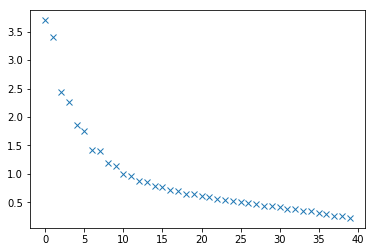

In [90]:
N = 70; a = 0.1; b = 2.12; omega = -0.066; Re=2000.
statInst = ops.statComp(N=N,Re=Re,a=a, b=b,covMat=np.identity(3*N))
statInst.U = 1.- statInst.y**2
statInst.dU= -2.*statInst.y
statInst.d2U = -2.*np.ones(N)
statInst.nu = np.ones(N)

y, DM = pseudo.chebdif(N,2)
D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]
Umat   = np.diag(1. - y**2)
dUmat  = np.diag(-2.*y)
d2Umat = -2.*np.identity(N)
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))

Delta = D2 - (a**2 + b**2) * I1
DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
DeltaInv = np.linalg.solve(Delta, I1)

LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
LSQ = -1.j*a*Umat + Delta/Re
Lco = -1.j*b*dUmat
k2 = a**2 + b**2
A = np.vstack(( 
        np.hstack(( DeltaInv @ LOS, Z1 )),
        np.hstack(( Lco           , LSQ)) ))
B = np.vstack((
        DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
        np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
C = (1./k2) * np.vstack((
        np.hstack((1.j*a*D1, -1.j*b*I1)),
        np.hstack((k2 * I1 , Z1       )),
        np.hstack((1.j*b*D1,  1.j*a*I1)) ))


res = ( 1.j*omega*I2 - A); resInv = np.linalg.solve(res,I2)
H = C @ resInv @ B
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']

Hw = W3s @ H @ W3si
svals = np.linalg.svd(Hw)[1]
plt.plot(np.log10(svals[:40]),'x')

plt.show()


## Fig. 8.6 Maximal singular values over frequency space

In [126]:
# Initialization
Re = 2000.       
# Grid
N = 40   # Wall-normal
aArr = 10.**np.linspace(-4., np.log10(3.02), 30)
bArr = 10**np.linspace(-2., np.log10(15.85), 60)
#aArr = np.array([1.])
#bArr = np.array([0., 1.])
wArr = 10**np.linspace(-3., np.log10(2.), 30)
aArr = np.concatenate((-aArr[::-1], [0.],aArr))
wArr = np.concatenate((-wArr[::-1], [0.],wArr))

# We're looking for \sigma_max of H_s for 
#     phi(y;a,b,omega) = [H_x  H_y  H_z](y;a,b,omega) [d_x; d_y; d_z](y)
# H_s has 3 components, so let's define an n_a x n_b x n_omega x 4 array
#                for the 3 components, and the total
svalsMaxArr = np.zeros((aArr.size, bArr.size, wArr.size, 4))

# While we're at it, let's generate fig. 8.2 as well 
# I don't have to do any additional SVD, just have to sum the svals,
#     and then integrate in omega space
HSnormArr = np.zeros((aArr.size, bArr.size, wArr.size, 4))

y, DM = pseudo.chebdif(N,2)
D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]
Umat   = np.diag(1. - y**2)
dUmat  = np.diag(-2.*y)
d2Umat = -2.*np.identity(N)
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']

def makeSystemTemp(a,b,omega):
    Delta = D2 - (a**2 + b**2) * I1
    DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
    DeltaInv = np.linalg.solve(Delta, I1)

    Q = 1./(a**2+b**2)* np.identity(2*N,dtype=np.complex)
    Q[:N,:N] = - Delta/(a**2+b**2)


    Qsqrt = W2s @ sqrtm(Q)
    QsqrtInv = np.linalg.solve(Qsqrt,I2)

    LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
    LSQ = -1.j*a*Umat + Delta/Re
    Lco = -1.j*b*dUmat
    k2 = a**2 + b**2
    A = np.vstack(( 
            np.hstack(( DeltaInv @ LOS, Z1 )),
            np.hstack(( Lco           , LSQ)) ))
    B = np.vstack((
            DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
            np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
    C = (1./k2) * np.vstack((
            np.hstack((1.j*a*D1, -1.j*b*I1)),
            np.hstack((k2 * I1 , Z1       )),
            np.hstack((1.j*b*D1,  1.j*a*I1)) ))
    res = ( 1.j*omega*I2 - A); resInv = np.linalg.solve(res,I2)
    H = C @ resInv @ B
    
    Hw = W3s @ H @ W3si
    return Hw

for i0 in range(aArr.size):
    a = aArr[i0]
    print("kx=",a)
    for i1 in range(bArr.size):
        b = bArr[i1]
        if (a == 0.) and (b==0.):
            continue
        for i2 in range(wArr.size):
            w = wArr[i2]
            H = makeSystemTemp(a,b,w)
            for i3 in range(3):
                Hs = H[:, i3*N: i3*N+N]
                svals = np.linalg.svd(Hs)[1]
                svalsMaxArr[i0,i1,i2,i3] = svals[0]
                HSnormArr[i0,i1,i2,i3] = np.sum( svals**2)
            svals = np.linalg.svd(H)[1]
            svalsMaxArr[i0,i1,i2,3] = svals[0]
            HSnormArr[i0,i1,i2,3] = np.sum( svals**2)

kx= -3.02
kx= -2.11604035039
kx= -1.48265786903
kx= -1.03886221082
kx= -0.727905416089
kx= -0.510025573414
kx= -0.35736248115
kx= -0.250395175439
kx= -0.175445792971
kx= -0.122930588487
kx= -0.0861344654093
kx= -0.0603523193262
kx= -0.0422873983224
kx= -0.0296297487295
kx= -0.0207608423455
kx= -0.0145466159308
kx= -0.0101924590302
kx= -0.00714160747601
kx= -0.00500395019399
kx= -0.00350614586815
kx= -0.00245667090442
kx= -0.00172132939118
kx= -0.00120609352584
kx= -0.000845080320207
kx= -0.000592127171151
kx= -0.000414889068449
kx= -0.000290702652242
kx= -0.000203688258976
kx= -0.00014271939566
kx= -0.0001
kx= 0.0
kx= 0.0001
kx= 0.00014271939566
kx= 0.000203688258976
kx= 0.000290702652242
kx= 0.000414889068449
kx= 0.000592127171151
kx= 0.000845080320207
kx= 0.00120609352584
kx= 0.00172132939118
kx= 0.00245667090442
kx= 0.00350614586815
kx= 0.00500395019399
kx= 0.00714160747601
kx= 0.0101924590302
kx= 0.0145466159308
kx= 0.0207608423455
kx= 0.0296297487295
kx= 0.0422873983224
kx= 0.0603

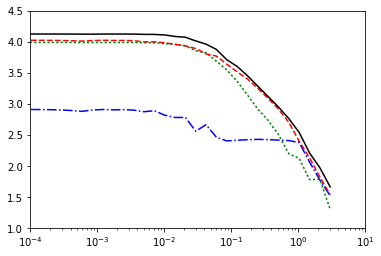

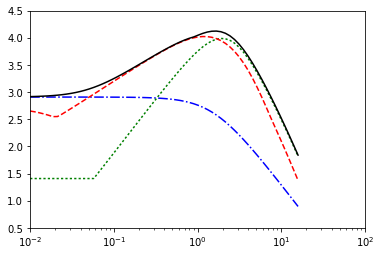

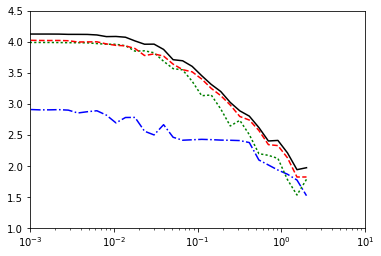

In [147]:
# Max over kz and omega
svalsMaxKx = np.amax(svalsMaxArr, axis=(1,2))
plt.plot(aArr, np.log10(svalsMaxKx[:,0]), 'b-.')
plt.plot(aArr, np.log10(svalsMaxKx[:,1]), 'g:')
plt.plot(aArr, np.log10(svalsMaxKx[:,2]), 'r--')
plt.plot(aArr, np.log10(svalsMaxKx[:,3]), 'k-')
plt.xscale("log")
plt.ylim([1,4.5]); plt.xlim([0.0001,10.])
plt.savefig(figureFolder+'fig8p6a.eps',format='eps')
plt.show()

# Max over kx and omega
svalsMaxKz = np.amax(svalsMaxArr, axis=(0,2))
plt.plot(bArr, np.log10(svalsMaxKz[:,0]), 'b-.')
plt.plot(bArr, np.log10(svalsMaxKz[:,1]), 'g:')
plt.plot(bArr, np.log10(svalsMaxKz[:,2]), 'r--')
plt.plot(bArr, np.log10(svalsMaxKz[:,3]), 'k-')
plt.xscale("log")
plt.ylim([0.5,4.5]); plt.xlim([0.01,100.])
plt.savefig(figureFolder+'fig8p6b.eps',format='eps')
plt.show()

# Max over kx and kz
svalsMaxW = np.amax(svalsMaxArr, axis=(0,1))
plt.plot(wArr, np.log10(svalsMaxW[:,0]), 'b-.')
plt.plot(wArr, np.log10(svalsMaxW[:,1]), 'g:')
plt.plot(wArr, np.log10(svalsMaxW[:,2]), 'r--')
plt.plot(wArr, np.log10(svalsMaxW[:,3]), 'k-')
plt.xscale("log")
plt.ylim([1.,4.5]); plt.xlim([0.001,10.])
plt.savefig(figureFolder+'fig8p6c.eps',format='eps')
plt.show()

## Fig. 8.2 from integration over $\omega$

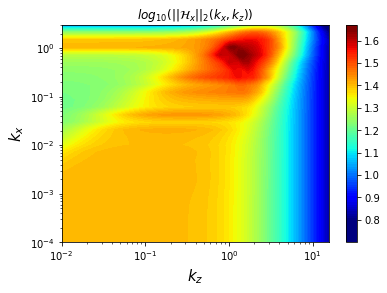

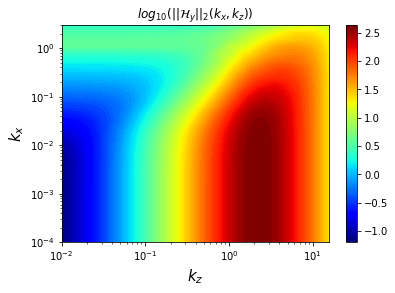

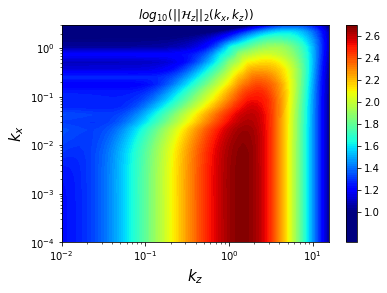

In [152]:
if False:
    # Integral in dw as a sum:
    #  \sum   H_{HS} dw = \sum w H_{HS} d(log w) = d(log w) \sum w H_{HS}
    #                                       since d(log w) is a constant
    # No, this doesn't work, coz we go positive and negative for w. Let's do the simple trapezoid rule on w instead
    wTimesHSnormArr = wArr.reshape((1,1,wArr.size,1)) * HSnormArr
    H2normArr2 = np.log10(wArr[-1]/wArr[-2]) * np.sum(wTimesHSnormArr,axis=2) / (2.*np.pi)
    
else:
    H2normArr2 = np.trapz(HSnormArr, x=wArr, axis=2)/(2.*np.pi)
H2normArr = np.sqrt(H2normArr2)    
    
na = aArr.size//2+1; nb= 0
plt.contourf(bArr[nb:], aArr[na:], np.log10(H2normArr[na:,nb:,0]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.clim([0.8,1.65])
plt.colorbar(ticks=np.arange(0.8,1.65,0.1))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{x}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p2a.eps',format='eps')
plt.show()

plt.contourf(bArr[nb:], aArr[na:], np.log10(H2normArr[na:,nb:,1]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.clim([-1.15,2.6])
plt.colorbar(ticks=np.arange(-1., 2.6,0.5))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{y}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p2b.eps',format='eps')
plt.show()

plt.contourf(bArr[nb:], aArr[na:], np.log10(H2normArr[na:,nb:,2]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.clim([1.,2.7])
plt.colorbar(ticks=np.arange(1., 2.7,0.2))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{z}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p2c.eps',format='eps')
plt.show()


## Fig. 8.8 Singular vectors

Using parameters Re=2000, alfa=25.4, kapa=0.426, N=40
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


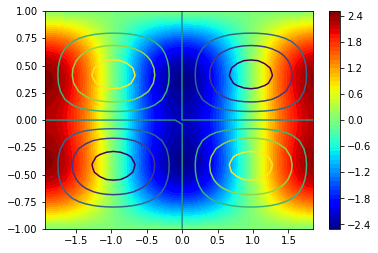

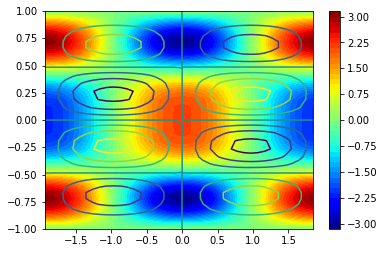

In [193]:
N = 40; a = 0.; b = 1.62; omega = 0.; Re=2000.
statInst = ops.statComp(N=N,Re=Re,a=a, b=b,covMat=np.identity(3*N))
statInst.U = 1.- statInst.y**2
statInst.dU= -2.*statInst.y
statInst.d2U = -2.*np.ones(N)
statInst.nu = np.ones(N)

y, DM = pseudo.chebdif(N,2)
D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]
Umat   = np.diag(1. - y**2)
dUmat  = np.diag(-2.*y)
d2Umat = -2.*np.identity(N)
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))

Delta = D2 - (a**2 + b**2) * I1
DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
DeltaInv = np.linalg.solve(Delta, I1)

LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
LSQ = -1.j*a*Umat + Delta/Re
Lco = -1.j*b*dUmat
k2 = a**2 + b**2
A = np.vstack(( 
        np.hstack(( DeltaInv @ LOS, Z1 )),
        np.hstack(( Lco           , LSQ)) ))
B = np.vstack((
        DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
        np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
C = (1./k2) * np.vstack((
        np.hstack((1.j*a*D1, -1.j*b*I1)),
        np.hstack((k2 * I1 , Z1       )),
        np.hstack((1.j*b*D1,  1.j*a*I1)) ))


res = ( 1.j*omega*I2 - A); resInv = np.linalg.solve(res,I2)
H = C @ resInv @ B
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']

Hw = W3s @ H @ W3si
U, svals, VH = np.linalg.svd(Hw)
# De-weighted velocity fields with the largest amplification
mode1 = W3si @ U[:,1]
mode2 = W3si @ U[:,3]

zArr = np.arange(-np.pi/b, np.pi/b, np.pi/b/20.)
Z = np.tile(zArr.reshape(1,zArr.size), [N,1])
Y = np.tile(y.reshape(N,1), [1,zArr.size])

u1 = 2.*mode1.real[:N].reshape((N,1)) * np.cos(b*Z) - 2.*mode1.imag[:N].reshape((N,1)) * np.sin(b*Z)
sf1c = -1.j*mode1[N:2*N]/b
strFun1 = 2.*sf1c.real.reshape((N,1)) * np.cos(b*Z) - 2.*sf1c.imag.reshape((N,1)) * np.sin(b*Z)

u2 = 2.*mode2.real[:N].reshape((N,1)) * np.cos(b*Z) - 2.*mode2.imag[:N].reshape((N,1)) * np.sin(b*Z)
sf2c = -1.j*mode2[N:2*N]/b
strFun2 = 2.*sf2c.real.reshape((N,1)) * np.cos(b*Z) - 2.*sf2c.imag.reshape((N,1)) * np.sin(b*Z)

plt.contourf(Z, Y, u1, 50,cmap='jet')
plt.colorbar()
plt.contour(Z, Y, strFun1)
plt.savefig(figureFolder+'fig8p8a.eps',format='eps')
plt.show()

plt.contourf(Z, Y, u2, 50,cmap='jet')
plt.colorbar()
plt.contour(Z, Y, strFun2)
plt.savefig(figureFolder+'fig8p8b.eps',format='eps')
plt.show()



This is a bit funny. The singular vectors I plotted aren't the first and second, but second and fourth. They're the most amplified symmetric modes. The antisymmetric modes are more amplified than the symmetric ones. There's something going on here. 

## Fig. 8.12, 8.13 H2 norms for Couette flow with Re=2000

In [203]:
# Initialization
Re = 2000.       
# Grid
N = 40   # Wall-normal
aArr = 10.**np.linspace(-4., 0.5, 20)
bArr = 10**np.linspace(-2., 1.5, 35)
#aArr = np.array([1.])
#bArr = np.array([0., 1.])
#wArr = 10**np.linspace(-3., 0.5, 44)
#aArr = np.concatenate((-aArr[::-1], [0.],aArr))
#wArr = np.concatenate((-wArr[::-1], [0.],wArr))


# H_{rs} has 9 components, so let's define a 3x3 matrix for each a,b,omega,
#  actually, a 4x4 to include H_{r} and H_{s}
amplArr = np.zeros((aArr.size, bArr.size, 4,4))
# Forcing covariance (Ws) for each $s$ component:
Ws = np.zeros((3,3*N,3*N),dtype=np.complex)
Ws[0,  :N ,:N   ] = np.identity(N) 
Ws[1,N:2*N,N:2*N] = np.identity(N)
Ws[2,2*N: ,2*N: ] = np.identity(N)

y, DM = pseudo.chebdif(N,2)
D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]
Umat   = np.diag(y)
dUmat  = np.identity(N)
d2Umat = np.zeros((N,N))
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']

for i0 in range(aArr.size):
    statInst.a = aArr[i0]
    a = aArr[i0]
    print("a=",a)
    for i1 in range(bArr.size):
        statInst.b = bArr[i1]
        b = bArr[i1]
        if (statInst.a == 0.) and (statInst.b==0.):
            continue
        #A,C,B = statInst.makeSystemNew()
        Delta = D2 - (a**2 + b**2) * I1
        DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
        DeltaInv = np.linalg.solve(Delta, I1)
        
        Q = 1./(a**2+b**2)* np.identity(2*N,dtype=np.complex)
        Q[:N,:N] = - Delta/(a**2+b**2)
        
        
        Qsqrt = W2s @ sqrtm(Q)
        QsqrtInv = np.linalg.solve(Qsqrt,I2)
        
        LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
        LSQ = -1.j*a*Umat + Delta/Re
        Lco = -1.j*b*dUmat
        k2 = a**2 + b**2
        A = np.vstack(( 
                np.hstack(( DeltaInv @ LOS, Z1 )),
                np.hstack(( Lco           , LSQ)) ))
        LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
        Lcoadj = -1.j*b*DeltaInv @ dUmat
        LSQadj = 1.j*a*Umat + Delta/Re
        Aadj = np.vstack((
                np.hstack(( LOSadj, Lcoadj)),
                np.hstack(( Z1    , LSQadj))  ))
        B = np.vstack((
                DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
                np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
        C = (1./k2) * np.vstack((
                np.hstack((1.j*a*D1, -1.j*b*I1)),
                np.hstack((k2 * I1 , Z1       )),
                np.hstack((1.j*b*D1,  1.j*a*I1)) ))
        #Apsi = Qsqrt @ A @ QsqrtInv
        #Bpsi = Qsqrt @ B @ W3si
        #Cpsi = W3s @ C @ QsqrtInv
        Badj = C; Cadj = B
        for i3 in range(3):
            #X = solve_lyapunov( A, -np.identity(2*N) )
            #X = solve_lyapunov( Apsi, -Bpsi @ Ws[i3] @ Bpsi.conj().T )
            X = solve_sylvester( A, Aadj, -B @ Ws[i3] @ Badj )
            Phi = C @ X @ Cadj
            
            amplArr[i0,i1,0,i3]  = np.trace(Phi[:N   ,:N   ].real)
            amplArr[i0,i1,1,i3]  = np.trace(Phi[N:2*N,N:2*N].real)
            amplArr[i0,i1,2,i3]  = np.trace(Phi[2*N: ,2*N: ].real)
            amplArr[i0,i1,3,i3]  = np.trace(Phi.real)
        X = solve_sylvester( A, Aadj, -B @  Badj )
        Phi = C @ X @ Cadj

        amplArr[i0,i1,0,3]  = np.trace(Phi[:N   ,:N   ].real)
        amplArr[i0,i1,1,3]  = np.trace(Phi[N:2*N,N:2*N].real)
        amplArr[i0,i1,2,3]  = np.trace(Phi[2*N: ,2*N: ].real)
        amplArr[i0,i1,3,3]  = np.trace(Phi.real)
amplArr2Couette = amplArr.copy()

a= 0.0001
a= 0.000172521054994
a= 0.000297635144163
a= 0.000513483290744
a= 0.00088586679041
a= 0.00152830673266
a= 0.00263665089873
a= 0.004548777947
a= 0.00784759970351
a= 0.0135387618002
a= 0.0233572146909
a= 0.040296113202
a= 0.0695192796178
a= 0.119935394621
a= 0.206913808111
a= 0.356969884683
a= 0.615848211066
a= 1.06246783089
a= 1.83298071083
a= 3.16227766017


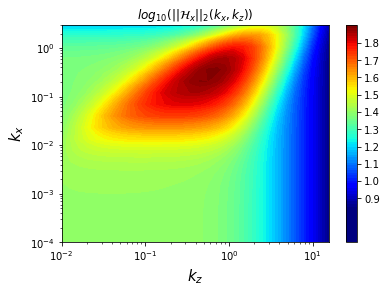

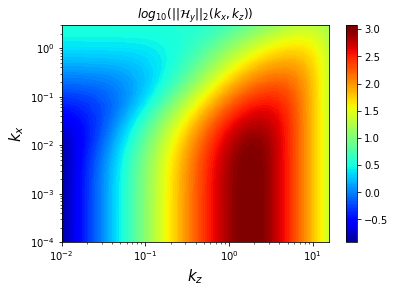

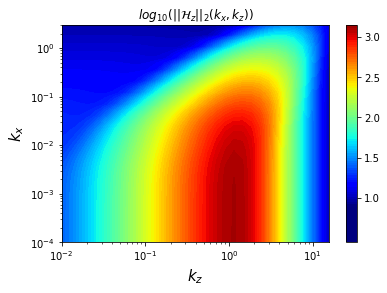

In [204]:
amplArr = np.sqrt(amplArr2Couette)
plt.contourf(bArr, aArr, np.log10(amplArr[:,:,3,0]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([0.85,1.9])
plt.colorbar(ticks=np.arange(0.9,1.85,0.1))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{x}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p12a.eps',format='eps')
plt.show()


plt.contourf(bArr, aArr, np.log10(amplArr[:,:,3,1]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([-1.,3.])
plt.colorbar(ticks=np.arange(-0.5,3.1,0.5))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{y}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p12b.eps',format='eps')
plt.show()

plt.contourf(bArr, aArr, np.log10(amplArr[:,:,3,2]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([0.9,3.2])
plt.colorbar(ticks=np.arange(1.,3.1,0.5))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{z}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p12c.eps',format='eps')
plt.show()

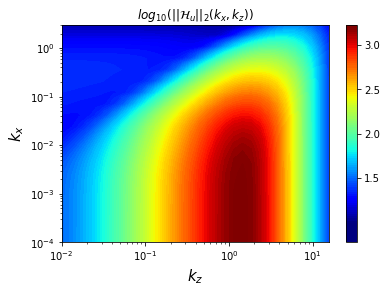

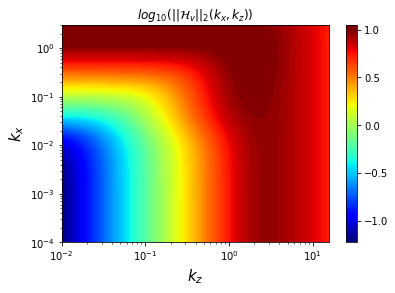

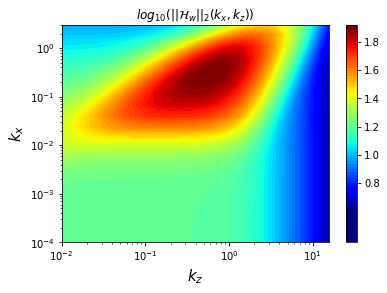

In [206]:
amplArr = np.sqrt(amplArr2Couette)
plt.contourf(bArr, aArr, np.log10(amplArr[:,:,0,3]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([1.,3.2])
plt.colorbar(ticks=np.arange(1.5,3.1,0.5))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{u}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p13a.eps',format='eps')
plt.show()


plt.contourf(bArr, aArr, np.log10(amplArr[:,:,1,3]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([-1.2,1.])
plt.colorbar(ticks=np.arange(-1.,1.1,0.5))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{v}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p13b.eps',format='eps')
plt.show()

plt.contourf(bArr, aArr, np.log10(amplArr[:,:,2,3]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([0.6,1.9])
plt.colorbar(ticks=np.arange(0.8,1.9,0.2))
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{w}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p13c.eps',format='eps')
plt.show()

## Fig. 8.15, 8.16    H2 norms for channel flow with turbulent mean

In [207]:
# Initialization
Re = 590.       
# Grid
N = 40   # Wall-normal
aArr = 10.**np.linspace(-4., 0.5, 20)
bArr = 10**np.linspace(-2., 1.5, 35)
#aArr = np.array([1.])
#bArr = np.array([0., 1.])
#wArr = 10**np.linspace(-3., 0.5, 44)
#aArr = np.concatenate((-aArr[::-1], [0.],aArr))
#wArr = np.concatenate((-wArr[::-1], [0.],wArr))


# H_{rs} has 9 components, so let's define a 3x3 matrix for each a,b,omega,
#  actually, a 4x4 to include H_{r} and H_{s}
amplArr = np.zeros((aArr.size, bArr.size, 4,4))
# Forcing covariance (Ws) for each $s$ component:
Ws = np.zeros((3,3*N,3*N),dtype=np.complex)
Ws[0,  :N ,:N   ] = np.identity(N) 
Ws[1,N:2*N,N:2*N] = np.identity(N)
Ws[2,2*N: ,2*N: ] = np.identity(N)

# Defining turbulent mean
turbDict = ops.turbMeanChannel(N=N, Re=Re)
y, DM = pseudo.chebdif(N,2)
D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]
Umat   = np.diag(turbDict['U'])
dUmat  = np.diag(turbDict['dU'])
d2Umat = np.diag(turbDict['d2U'])
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']

for i0 in range(aArr.size):
    statInst.a = aArr[i0]
    a = aArr[i0]
    print("a=",a)
    for i1 in range(bArr.size):
        statInst.b = bArr[i1]
        b = bArr[i1]
        if (statInst.a == 0.) and (statInst.b==0.):
            continue
        #A,C,B = statInst.makeSystemNew()
        Delta = D2 - (a**2 + b**2) * I1
        DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
        DeltaInv = np.linalg.solve(Delta, I1)
        
        Q = 1./(a**2+b**2)* np.identity(2*N,dtype=np.complex)
        Q[:N,:N] = - Delta/(a**2+b**2)
        
        
        Qsqrt = W2s @ sqrtm(Q)
        QsqrtInv = np.linalg.solve(Qsqrt,I2)
        
        LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
        LSQ = -1.j*a*Umat + Delta/Re
        Lco = -1.j*b*dUmat
        k2 = a**2 + b**2
        A = np.vstack(( 
                np.hstack(( DeltaInv @ LOS, Z1 )),
                np.hstack(( Lco           , LSQ)) ))
        LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
        Lcoadj = -1.j*b*DeltaInv @ dUmat
        LSQadj = 1.j*a*Umat + Delta/Re
        Aadj = np.vstack((
                np.hstack(( LOSadj, Lcoadj)),
                np.hstack(( Z1    , LSQadj))  ))
        B = np.vstack((
                DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
                np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
        C = (1./k2) * np.vstack((
                np.hstack((1.j*a*D1, -1.j*b*I1)),
                np.hstack((k2 * I1 , Z1       )),
                np.hstack((1.j*b*D1,  1.j*a*I1)) ))
        #Apsi = Qsqrt @ A @ QsqrtInv
        #Bpsi = Qsqrt @ B @ W3si
        #Cpsi = W3s @ C @ QsqrtInv
        Badj = C; Cadj = B
        for i3 in range(3):
            #X = solve_lyapunov( A, -np.identity(2*N) )
            #X = solve_lyapunov( Apsi, -Bpsi @ Ws[i3] @ Bpsi.conj().T )
            X = solve_sylvester( A, Aadj, -B @ Ws[i3] @ Badj )
            Phi = C @ X @ Cadj
            
            amplArr[i0,i1,0,i3]  = np.trace(Phi[:N   ,:N   ].real)
            amplArr[i0,i1,1,i3]  = np.trace(Phi[N:2*N,N:2*N].real)
            amplArr[i0,i1,2,i3]  = np.trace(Phi[2*N: ,2*N: ].real)
            amplArr[i0,i1,3,i3]  = np.trace(Phi.real)
        X = solve_sylvester( A, Aadj, -B @  Badj )
        Phi = C @ X @ Cadj

        amplArr[i0,i1,0,3]  = np.trace(Phi[:N   ,:N   ].real)
        amplArr[i0,i1,1,3]  = np.trace(Phi[N:2*N,N:2*N].real)
        amplArr[i0,i1,2,3]  = np.trace(Phi[2*N: ,2*N: ].real)
        amplArr[i0,i1,3,3]  = np.trace(Phi.real)
amplArr2Turb = amplArr.copy()

Using parameters Re=590, alfa=25.4, kapa=0.426, N=40
a= 0.0001
a= 0.000172521054994
a= 0.000297635144163
a= 0.000513483290744
a= 0.00088586679041
a= 0.00152830673266
a= 0.00263665089873
a= 0.004548777947
a= 0.00784759970351
a= 0.0135387618002
a= 0.0233572146909
a= 0.040296113202
a= 0.0695192796178
a= 0.119935394621
a= 0.206913808111
a= 0.356969884683
a= 0.615848211066
a= 1.06246783089
a= 1.83298071083
a= 3.16227766017


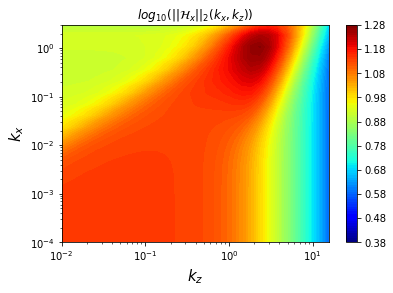

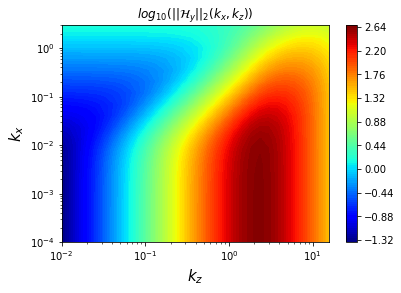

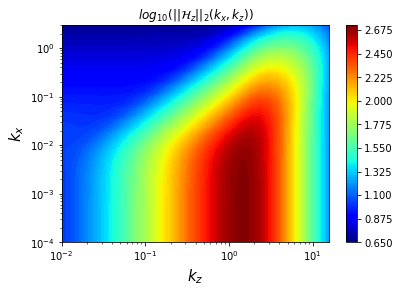

In [208]:
amplArr = np.sqrt(amplArr2Turb)
plt.contourf(bArr, aArr, np.log10(amplArr[:,:,3,0]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
#plt.clim([0.85,1.6])
#plt.colorbar(ticks=np.arange(0.9,1.55,0.1))
plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{x}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p15a.eps',format='eps')
plt.show()


plt.contourf(bArr, aArr, np.log10(amplArr[:,:,3,1]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
#plt.clim([0.85,1.6])
#plt.clim([-1.5,2.55])
#plt.colorbar(ticks=np.arange(-1.5,2.6,0.5))
plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{y}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p15b.eps',format='eps')
plt.show()

plt.contourf(bArr, aArr, np.log10(amplArr[:,:,3,2]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
#plt.clim([0.85,1.6])
#plt.clim([-1.5,2.55])
#plt.colorbar(ticks=np.arange(-1.,2.6,0.5))
plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{z}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p15c.eps',format='eps')
plt.show()

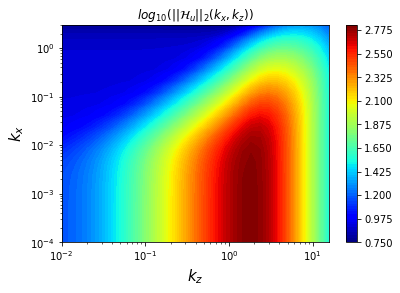

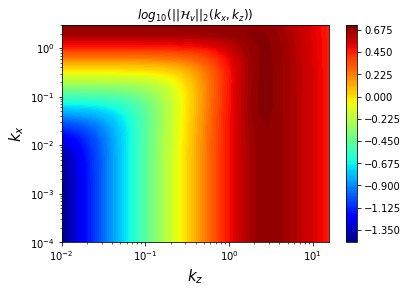

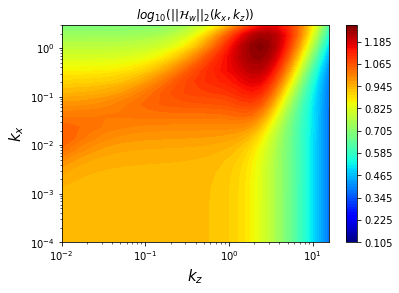

In [210]:
amplArr = np.sqrt(amplArr2Turb)
plt.contourf(bArr, aArr, np.log10(amplArr[:,:,0,3]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
#plt.clim([0.85,1.6])
#plt.colorbar(ticks=np.arange(0.9,1.55,0.1))
plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{u}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p16a.eps',format='eps')
plt.show()


plt.contourf(bArr, aArr, np.log10(amplArr[:,:,1,3]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
#plt.clim([0.85,1.6])
#plt.clim([-1.5,2.55])
#plt.colorbar(ticks=np.arange(-1.5,2.6,0.5))
plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{v}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p16b.eps',format='eps')
plt.show()

plt.contourf(bArr, aArr, np.log10(amplArr[:,:,2,3]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
#plt.clim([0.85,1.6])
#plt.clim([-1.5,2.55])
#plt.colorbar(ticks=np.arange(-1.,2.6,0.5))
plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{H}_{w}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig8p16c.eps',format='eps')
plt.show()

# Laminar impulse response

The impulse function (in $y$) is defined as
$$ f_s(y) = \frac{1}{2\sqrt{\pi\epsilon}} e^{ -\frac{(y-y_0)^2}{4\epsilon}}, \quad \epsilon > 0 $$
The values used for $y_0$ and $\epsilon$ are $y_0 = -0.9$ and $\epsilon = 1/2000$.

The state equation is
$$ \phi(y;k_x,k_z,t) = \mathcal{G}(y;k_x,k_z,t)  $$
where $\mathcal{G}$ is computed as an impulse response. 

The amplifications, $||G_s||_2 $, are defined as integrated HS norms over wavenumber and temporal spaces in Eq. 10.3, 10.4


## Fig. 10.2   $||\mathcal{G}_s||_2(k_z)$ for streamwise constant perturbations

In [120]:
startTime = time.time()
# Initialization
Re = 2000.       
# Grid
N = 250   # Wall-normal
aArr = np.array([0.])
nb = 256
bArr = np.linspace(15./nb, 15., nb)


# G_{s} has 3 components, so 
Gs2 = np.zeros((aArr.size, bArr.size, 4))

y, DM = pseudo.chebdif(N,2)

# Impulse function
y0 = -0.9; eps = 1./2000.
fs = 1./(2.*np.sqrt(np.pi * eps )) * np.exp(-(y-y0)**2 / 4./eps )

# Impulse input to the velocity vorticity state (i.e., B*fs)
# Since there are 3 fs (and a total), I'll use Fs of size 4x2N
Fs = np.zeros((4, 2*N), dtype=np.complex)
Fsadj = Fs.copy()

D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]

Umat   = np.diag(1. - y**2)
dUmat  = np.diag(- 2.*y)
d2Umat  = -2.*np.identity(N)
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']

for i0 in range(aArr.size):
    a = aArr[i0]
    for i1 in range(bArr.size):
        b = bArr[i1]
        print("b=",b)
        #A,C,B = statInst.makeSystemNew()
        Delta = D2 - (a**2 + b**2) * I1
        DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
        DeltaInv = np.linalg.solve(Delta, I1)
        
        LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
        LSQ = -1.j*a*Umat + Delta/Re
        Lco = -1.j*b*dUmat
        k2 = a**2 + b**2
        A = np.vstack(( 
                np.hstack(( DeltaInv @ LOS, Z1 )),
                np.hstack(( Lco           , LSQ)) ))
        LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
        Lcoadj = -1.j*b*DeltaInv @ dUmat
        LSQadj = 1.j*a*Umat + Delta/Re
        Aadj = np.vstack((
                np.hstack(( LOSadj, Lcoadj)),
                np.hstack(( Z1    , LSQadj))  ))
        B = np.vstack((
                DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
                np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
        C = (1./k2) * np.vstack((
                np.hstack((1.j*a*D1, -1.j*b*I1)),
                np.hstack((k2 * I1 , Z1       )),
                np.hstack((1.j*b*D1,  1.j*a*I1)) ))
        Badj = C; Cadj = B
        
        Fs[0,:N] = -1.j*a*DeltaInv @ (D1@fs);  Fs[0,N:] = 1.j*b*fs
        Fs[1,:N] = -(a**2+b**2)*DeltaInv @ fs; Fs[1,N:] = 0.
        Fs[2,:N] = -1.j*b*DeltaInv @ (D1@fs);  Fs[2,N:] = -1.j*a*fs
        Fs[3] = Fs[0]+Fs[1]+Fs[2]
        
        Fsadj[0] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*a*D1@fs, -1.j*b*fs  ))
        Fsadj[1] = W2 @ np.concatenate(( fs, np.zeros(N,dtype=np.complex) ))
        Fsadj[2] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*b*D1@fs,  1.j*a*fs  ))
        Fsadj[3] = Fsadj[0] + Fsadj[1] + Fsadj[2]
        
        Y = solve_sylvester( Aadj, A, -Cadj @ C )
        for i3 in range(4):
            Gs2[i0,i1,i3]  = np.real(np.trace( Fsadj[i3].reshape((1,2*N)) @ Y @ Fs[i3].reshape((2*N,1)) ))

print("Time elapsed (s):%d" %(time.time()-startTime))        

b= 0.05859375
b= 0.1171875
b= 0.17578125
b= 0.234375
b= 0.29296875
b= 0.3515625
b= 0.41015625
b= 0.46875
b= 0.52734375
b= 0.5859375
b= 0.64453125
b= 0.703125
b= 0.76171875
b= 0.8203125
b= 0.87890625
b= 0.9375
b= 0.99609375
b= 1.0546875
b= 1.11328125
b= 1.171875
b= 1.23046875
b= 1.2890625
b= 1.34765625
b= 1.40625
b= 1.46484375
b= 1.5234375
b= 1.58203125
b= 1.640625
b= 1.69921875
b= 1.7578125
b= 1.81640625
b= 1.875
b= 1.93359375
b= 1.9921875
b= 2.05078125
b= 2.109375
b= 2.16796875
b= 2.2265625
b= 2.28515625
b= 2.34375
b= 2.40234375
b= 2.4609375
b= 2.51953125
b= 2.578125
b= 2.63671875
b= 2.6953125
b= 2.75390625
b= 2.8125
b= 2.87109375
b= 2.9296875
b= 2.98828125
b= 3.046875
b= 3.10546875
b= 3.1640625
b= 3.22265625
b= 3.28125
b= 3.33984375
b= 3.3984375
b= 3.45703125
b= 3.515625
b= 3.57421875
b= 3.6328125
b= 3.69140625
b= 3.75
b= 3.80859375
b= 3.8671875
b= 3.92578125
b= 3.984375
b= 4.04296875
b= 4.1015625
b= 4.16015625
b= 4.21875
b= 4.27734375
b= 4.3359375
b= 4.39453125
b= 4.453125
b= 4.5117

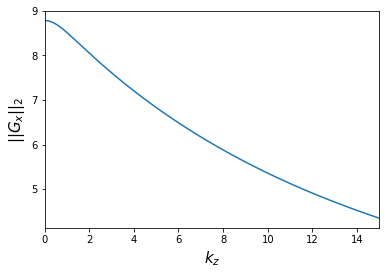

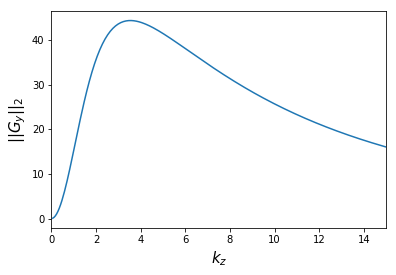

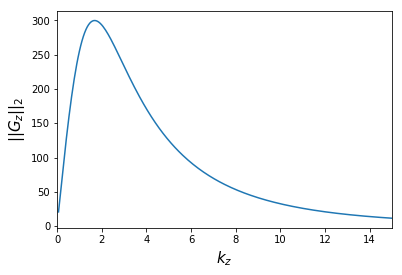

In [233]:
Gs = np.sqrt(2.*Gs2)
# I suppose the factor 2 is there to account for -beta
plt.plot(bArr, Gs[0,:,0])
plt.xlim([0., 15.])
plt.xlabel('$k_z$',fontsize=15); plt.ylabel('$||G_x||_2$',fontsize=15)
plt.savefig(figureFolder+'fig10p2a.eps',format='eps')
plt.show()

plt.plot(bArr, Gs[0,:,1])
plt.xlim([0., 15.])
plt.xlabel('$k_z$',fontsize=15); plt.ylabel('$||G_y||_2$',fontsize=15)
plt.savefig(figureFolder+'fig10p2b.eps',format='eps')
plt.show()

plt.plot(bArr, Gs[0,:,2])
plt.xlim([0., 15.])
plt.xlabel('$k_z$',fontsize=15); plt.ylabel('$||G_z||_2$',fontsize=15)
plt.savefig(figureFolder+'fig10p2c.eps',format='eps')
plt.show()



## Fig. 10.3 Impulse amplification integrated over wavenumber space
The integral of the HS norm over time can be obtained as the H2 norm, but the integral of the HS norm over wavenumber space, not so much. We need to compute the HS norms individually and then integrate them. 

In [242]:
# Initialization
Re = 2000.       
# Grid
N = 50   # Wall-normal
aArr = np.array([0.])
nb = 256
bArr = np.linspace(200./nb,200., nb)
tArr = np.concatenate(( np.arange(1.,5.1),np.arange(7.5,51.,2.5), np.arange(55., 101., 5.), np.arange(100., 201.,20.) ))

# We need HS norm at each b and t for three components, Gx, Gy, Gz; I'll not do the extra Gtotal
HSnormArr = np.zeros((tArr.size, bArr.size, 3))

y, DM = pseudo.chebdif(N,2)

# Impulse function
y0 = -0.9; eps = 1./2000.
fs = 1./(2.*np.sqrt(np.pi * eps )) * np.exp(-(y-y0)**2 / 4./eps )

# Impulse input to the velocity vorticity state (i.e., B*fs)
# Since there are 3 fs (and a total), I'll use Fs of size 4x2N
Fs = np.zeros((4, 2*N), dtype=np.complex)
Fsadj = Fs.copy()

D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]
Umat   = np.diag(1. - y**2)
dUmat  = np.diag(-2.*y)
d2Umat = -2.*np.identity(N)
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']

def makeSystemTemp(a,b):
    # This time, we don't need the resolvent, but just the system matrices and their adjoints.
    Delta = D2 - (a**2 + b**2) * I1
    DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
    DeltaInv = np.linalg.solve(Delta, I1)

    LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
    LSQ = -1.j*a*Umat + Delta/Re
    Lco = -1.j*b*dUmat
    k2 = a**2 + b**2
    A = np.vstack(( 
            np.hstack(( DeltaInv @ LOS, Z1 )),
            np.hstack(( Lco           , LSQ)) ))
    LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
    Lcoadj = -1.j*b*DeltaInv @ dUmat
    LSQadj = 1.j*a*Umat + Delta/Re
    Aadj = np.vstack((
            np.hstack(( LOSadj, Lcoadj)),
            np.hstack(( Z1    , LSQadj))  ))
    B = np.vstack((
            DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
            np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
    C = (1./k2) * np.vstack((
            np.hstack((1.j*a*D1, -1.j*b*I1)),
            np.hstack((k2 * I1 , Z1       )),
            np.hstack((1.j*b*D1,  1.j*a*I1)) ))
    Badj = C; Cadj = B

    Fs[0,:N] = -1.j*a*DeltaInv @ (D1@fs);  Fs[0,N:] = 1.j*b*fs
    Fs[1,:N] = -(a**2+b**2)*DeltaInv @ fs; Fs[1,N:] = 0.
    Fs[2,:N] = -1.j*b*DeltaInv @ (D1@fs);  Fs[2,N:] = -1.j*a*fs
    Fs[3] = Fs[0]+Fs[1]+Fs[2]

    Fsadj[0] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*a*D1@fs, -1.j*b*fs  ))
    Fsadj[1] = W2 @ np.concatenate(( fs, np.zeros(N,dtype=np.complex) ))
    Fsadj[2] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*b*D1@fs,  1.j*a*fs  ))
    Fsadj[3] = Fsadj[0] + Fsadj[1] + Fsadj[2]
    return A,Aadj, C, Cadj, Fs, Fsadj

a = 0.
for i0 in range(tArr.size):
    t = tArr[i0]
    print("t=",t)
    for i1 in range(bArr.size):
        b = bArr[i1]
        if i1%50 == 0: print("b=",b)
        A,Aadj, C,Cadj, Fs,Fsadj = makeSystemTemp(a,b)
        for i2 in range(3):
            Fst = Fs[i2].reshape((2*N,1)); Fsadjt = Fsadj[i2].reshape((1,2*N))
            HSnormArr[i0,i1,i2]= np.trace(
                C @ expm(t*A) @ Fst @ Fsadjt @ expm(t*Aadj) @ Cadj )
HSnormArrImpulseKz = HSnormArr.copy()            
        

t= 1.0
b= 0.78125


/home/svadarevu/linenv/lib/python3.5/site-packages/ipykernel/__main__.py:78: ComplexWarning: Casting complex values to real discards the imaginary part


b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 2.0
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 3.0
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 4.0
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 5.0
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 7.5
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 10.0
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 12.5
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 15.0
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 17.5
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 20.0
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 22.5
b= 0.78125
b= 39.84375
b= 78.90625
b= 117.96875
b= 157.03125
b= 196.09375
t= 25.0
b= 0.78125
b= 39.84375
b= 78.906

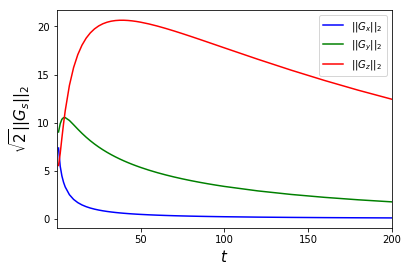

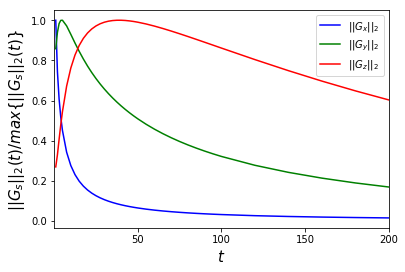

In [256]:
Gst2 = 4.*(1./2./np.pi) * np.trapz(HSnormArrImpulseKz,axis=1, dx = bArr[-1]-bArr[-2]) 
Gs = np.sqrt(Gst2)
# I suppose the factor 2 is there to account for -beta
plt.plot(tArr, Gs[:,0],'b-',label='$||G_x||_2$')
plt.plot(tArr, Gs[:,1],'g-',label='$||G_y||_2$')
plt.plot(tArr, Gs[:,2],'r-',label='$||G_z||_2$')
plt.xlim([0., 200.])
plt.xticks(np.arange(50., 201., 50.))
plt.xlabel('$t$',fontsize=15); plt.ylabel('$\sqrt{2}||G_s||_2$',fontsize=15)
plt.legend()
plt.savefig(figureFolder+'fig10p3a.eps',format='eps')
plt.show()

plt.plot(tArr, Gs[:,0]/np.max(Gs[:,0]),'b-',label='$||G_x||_2$')
plt.plot(tArr, Gs[:,1]/np.max(Gs[:,1]),'g-',label='$||G_y||_2$')
plt.plot(tArr, Gs[:,2]/np.max(Gs[:,2]),'r-',label='$||G_z||_2$')
plt.xlim([0., 200.])
plt.xticks(np.arange(50., 201., 50.))
plt.xlabel('$t$',fontsize=15); plt.ylabel('$||G_s||_2(t)/max\{||G_s||_2(t)\}$',fontsize=15)
plt.legend()
plt.savefig(figureFolder+'fig10p3b.eps',format='eps')
plt.show()



Again, this factor of 2 shows up in the squared norms. Is this just a silly mistake by the author, or did I get something wrong?

## Fig. 10.4  Velocity contours (in physical space including all wavenumbers) of impulse response

The impulse response at time $t$ for wavenumber pair $(k_x, k_z)$ is 
$$ \phi(y; k_x,k_z,t) = C(y;k_x,k_z) e^{A(y;k_x,k_z)t} F_s(y; k_x,k_z) $$, 
where $f_s$ was defined earlier. 

In [271]:
# Initialization
Re = 2000.       
# Grid
N = 50   # Wall-normal
aArr = np.array([0.])
nb = 512
bArr = np.linspace(15./nb, 15., nb)
tArr = np.array([5., 20., 100., 200.])

y, DM = pseudo.chebdif(N,2)

# Impulse function
y0 = -0.9; eps = 1./2000.
fs = 1./(2.*np.sqrt(np.pi * eps )) * np.exp(-(y-y0)**2 / 4./eps )

# Impulse input to the velocity vorticity state (i.e., B*fs)
# Since there are 3 fs (and a total), I'll use Fs of size 4x2N
Fs = np.zeros((4, 2*N), dtype=np.complex)
Fsadj = Fs.copy()

D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']


Umat   = np.diag(1. - y**2)
dUmat  = np.diag(- 2.*y)
d2Umat  = -2.*np.identity(N)
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))

def makeSystemTemp(a,b):
    # This time, we don't need the resolvent, but just the system matrices and their adjoints.
    Delta = D2 - (a**2 + b**2) * I1
    DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
    DeltaInv = np.linalg.solve(Delta, I1)

    LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
    LSQ = -1.j*a*Umat + Delta/Re
    Lco = -1.j*b*dUmat
    k2 = a**2 + b**2
    A = np.vstack(( 
            np.hstack(( DeltaInv @ LOS, Z1 )),
            np.hstack(( Lco           , LSQ)) ))
    LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
    Lcoadj = -1.j*b*DeltaInv @ dUmat
    LSQadj = 1.j*a*Umat + Delta/Re
    B = np.vstack((
            DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
            np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
    C = (1./k2) * np.vstack((
            np.hstack((1.j*a*D1, -1.j*b*I1)),
            np.hstack((k2 * I1 , Z1       )),
            np.hstack((1.j*b*D1,  1.j*a*I1)) ))
    Badj = C; Cadj = B

    Fs[0,:N] = -1.j*a*DeltaInv @ (D1@fs);  Fs[0,N:] = 1.j*b*fs
    Fs[1,:N] = -(a**2+b**2)*DeltaInv @ fs; Fs[1,N:] = 0.
    Fs[2,:N] = -1.j*b*DeltaInv @ (D1@fs);  Fs[2,N:] = -1.j*a*fs
    Fs[3] = Fs[0]+Fs[1]+Fs[2]

    return A,C, Fs

# Grid in physical space
zArr = np.linspace(-np.pi/2, np.pi/2, 80)
Z = np.tile(zArr.reshape((1,zArr.size)), [N,1])
Y = np.tile(y.reshape((N,1)),[1,zArr.size])

# We'll record the velocity components at each time instance here.
velField = np.zeros(( tArr.size, 3, N, zArr.size ))
strFunField = np.zeros(( tArr.size, N, zArr.size ))  #and the stream function


a = 0.
for i0 in range(tArr.size):
    t = tArr[i0]
    print("t=",t)
    for i1 in range(bArr.size):
        b = bArr[i1]
        if i1%50 == 0: print("b=",b)
        A, C, Fs = makeSystemTemp(a,b)
        
        # Response to impulse in spanwise
        velSpec = C @ expm(t*A) @ Fs[2].reshape((2*N,1))
        strFunSpec = - velSpec[N:2*N]/(1.j*b)
        velRe = velSpec.real; velIm = velSpec.imag
        # Adding up the field due to each Fourier mode
        # I could instead store the spectral fields and then do an inverse FFT, but whatever
        velField[i0,0] += 2.*velRe[   :N].reshape((N,1)) * np.cos(b*Z) - 2.*velIm[   :N].reshape((N,1)) * np.sin(b*Z)
        velField[i0,1] += 2.*velRe[N:2*N].reshape((N,1)) * np.cos(b*Z) - 2.*velIm[N:2*N].reshape((N,1)) * np.sin(b*Z)
        velField[i0,2] += 2.*velRe[2*N :].reshape((N,1)) * np.cos(b*Z) - 2.*velIm[2*N: ].reshape((N,1)) * np.sin(b*Z)
        strFunField[i0] += 2.*strFunSpec.real.reshape((N,1)) * np.cos(b*Z) - 2.*strFunSpec.imag.reshape((N,1)) * np.sin(b*Z)
velField = velField * (bArr[-1]-bArr[-2]) / (2.*np.pi)
strFunField = strFunField * (bArr[-1]-bArr[-2]) / (2.*np.pi)

t= 5.0
b= 0.029296875
b= 1.494140625
b= 2.958984375
b= 4.423828125
b= 5.888671875
b= 7.353515625
b= 8.818359375
b= 10.283203125
b= 11.748046875
b= 13.212890625
b= 14.677734375
t= 20.0
b= 0.029296875
b= 1.494140625
b= 2.958984375
b= 4.423828125
b= 5.888671875
b= 7.353515625
b= 8.818359375
b= 10.283203125
b= 11.748046875
b= 13.212890625
b= 14.677734375
t= 100.0
b= 0.029296875
b= 1.494140625
b= 2.958984375
b= 4.423828125
b= 5.888671875
b= 7.353515625
b= 8.818359375
b= 10.283203125
b= 11.748046875
b= 13.212890625
b= 14.677734375
t= 200.0
b= 0.029296875
b= 1.494140625
b= 2.958984375
b= 4.423828125
b= 5.888671875
b= 7.353515625
b= 8.818359375
b= 10.283203125
b= 11.748046875
b= 13.212890625
b= 14.677734375


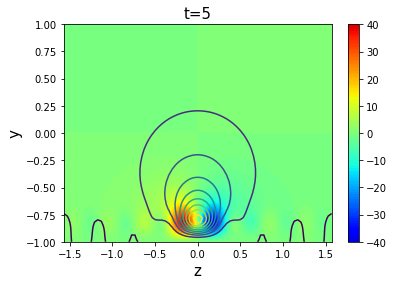

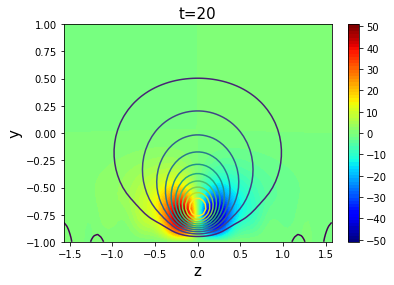

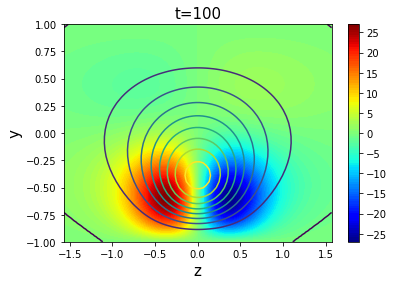

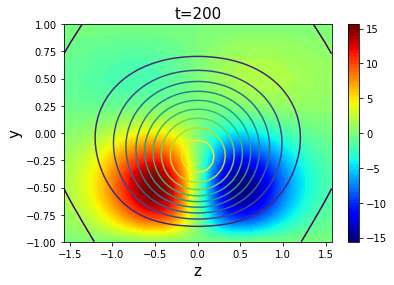

In [273]:
plt.contourf(Z,Y,velField[0,0],100, cmap="jet")
plt.clim([-47.,47.])
plt.colorbar(ticks=np.arange(-40.,41.,10.))
plt.contour( Z,Y,strFunField[0],10)
plt.xlabel("z", fontsize=15); plt.ylabel("y", fontsize=15)
plt.title("t=5",fontsize=15)
plt.savefig(figureFolder+'fig10p4a.eps',format='eps')
plt.show()

plt.contourf(Z,Y,velField[1,0],100, cmap="jet")
plt.clim([-50.,50.])
plt.colorbar(ticks=np.arange(-50.,51.,10.))
plt.contour( Z,Y,strFunField[1],10)
plt.xlabel("z", fontsize=15); plt.ylabel("y", fontsize=15)
plt.title("t=20",fontsize=15)
plt.savefig(figureFolder+'fig10p4b.eps',format='eps')
plt.show()

plt.contourf(Z,Y,velField[2,0],100, cmap="jet")
plt.clim([-27.,27.])
plt.colorbar(ticks=np.arange(-25.,26.,5.))
plt.contour( Z,Y,strFunField[2],10)
plt.xlabel("z", fontsize=15); plt.ylabel("y", fontsize=15)
plt.title("t=100",fontsize=15)
plt.savefig(figureFolder+'fig10p4c.eps',format='eps')
plt.show()

plt.contourf(Z,Y,velField[3,0],100, cmap="jet")
plt.clim([-15.,15.])
plt.colorbar(ticks=np.arange(-15.,16.,5.))
plt.contour( Z,Y,strFunField[3],10)
plt.xlabel("z", fontsize=15); plt.ylabel("y", fontsize=15)
plt.title("t=200",fontsize=15)
plt.savefig(figureFolder+'fig10p4d.eps',format='eps')
plt.show()

## Fig. 10.5  Impulse amplification for 3d perturbations

In [275]:
# Initialization
Re = 2000.       
# Grid
N = 50   # Wall-normal
aArr = 10.** np.linspace(-4., np.log10(3.02), 50)
bArr = 10.** np.linspace(-2., np.log10(15.84),90)

y, DM = pseudo.chebdif(N,2)

# Impulse function
y0 = -0.9; eps = 1./2000.
fs = 1./(2.*np.sqrt(np.pi * eps )) * np.exp(-(y-y0)**2 / 4./eps )

# Impulse input to the velocity vorticity state (i.e., B*fs)
# Since there are 3 fs (and a total), I'll use Fs of size 4x2N
Fs = np.zeros((4, 2*N), dtype=np.complex)
Fsadj = Fs.copy()

# H2 norm for each kx and kz, for impulse along x, y,z:
Gs2 = np.zeros((aArr.size, bArr.size, 3))

D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]

Umat   = np.diag(1. - y**2)
dUmat  = np.diag(- 2.*y)
d2Umat  = -2.*np.identity(N)
I1 = np.identity(N); I2 = np.identity(2*N)
Z1 = np.zeros((N,N))
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']


def makeSystemTemp(a,b):
    # This time, we don't need the resolvent, but just the system matrices and their adjoints.
    Delta = D2 - (a**2 + b**2) * I1
    DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
    DeltaInv = np.linalg.solve(Delta, I1)

    LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
    LSQ = -1.j*a*Umat + Delta/Re
    Lco = -1.j*b*dUmat
    k2 = a**2 + b**2
    A = np.vstack(( 
            np.hstack(( DeltaInv @ LOS, Z1 )),
            np.hstack(( Lco           , LSQ)) ))
    LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
    Lcoadj = -1.j*b*DeltaInv @ dUmat
    LSQadj = 1.j*a*Umat + Delta/Re
    Aadj = np.vstack((
            np.hstack(( LOSadj, Lcoadj)),
            np.hstack(( Z1    , LSQadj))  ))
    B = np.vstack((
            DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
            np.hstack((1.j*b*I1, Z1, -1.j*a*I1))  ))
    C = (1./k2) * np.vstack((
            np.hstack((1.j*a*D1, -1.j*b*I1)),
            np.hstack((k2 * I1 , Z1       )),
            np.hstack((1.j*b*D1,  1.j*a*I1)) ))
    Badj = C; Cadj = B

    Fs[0,:N] = -1.j*a*DeltaInv @ (D1@fs);  Fs[0,N:] = 1.j*b*fs
    Fs[1,:N] = -(a**2+b**2)*DeltaInv @ fs; Fs[1,N:] = 0.
    Fs[2,:N] = -1.j*b*DeltaInv @ (D1@fs);  Fs[2,N:] = -1.j*a*fs
    Fs[3] = Fs[0]+Fs[1]+Fs[2]

    Fsadj[0] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*a*D1@fs, -1.j*b*fs  ))
    Fsadj[1] = W2 @ np.concatenate(( fs, np.zeros(N,dtype=np.complex) ))
    Fsadj[2] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*b*D1@fs,  1.j*a*fs  ))
    Fsadj[3] = Fsadj[0] + Fsadj[1] + Fsadj[2]
    return A,Aadj, C, Cadj, Fs, Fsadj

for i0 in range(aArr.size):
    a = aArr[i0]
    print("a=",a)
    for i1 in range(bArr.size):
        b = bArr[i1]
        A,Aadj, C,Cadj, Fs,Fsadj = makeSystemTemp(a,b)
        Y = solve_sylvester( Aadj, A, -Cadj @ C )
        for i3 in range(3):
            Gs2[i0,i1,i3]  = np.real(np.trace( Fsadj[i3].reshape((1,2*N)) @ Y @ Fs[i3].reshape((2*N,1)) ))

GsKxKz2 = Gs2.copy()            


a= 0.0001
a= 0.000123432269175
a= 0.000152355250737
a= 0.000188055543192
a= 0.000232121224271
a= 0.000286512494354
a= 0.000353648873251
a= 0.000436516829165
a= 0.00053880262757
a= 0.000665056309583
a= 0.00082089409421
a= 0.00101324820801
a= 0.00125067525552
a= 0.0015437368479
a= 0.00190546942145
a= 0.00235196414533
a= 0.00290308271476
a= 0.00358334087085
a= 0.00442299894917
a= 0.00545940796854
a= 0.00673867113909
a= 0.00831769469922
a= 0.0102667193103
a= 0.0126724446145
a= 0.0156418859476
a= 0.0193071347669
a= 0.0238312345555
a= 0.0294154335842
a= 0.0363081371607
a= 0.0448159575926
a= 0.055317353409
a= 0.0682794645603
a= 0.0842788924873
a= 0.104027349433
a= 0.128403317967
a= 0.158491129063
a= 0.195629197043
a= 0.241469557079
a= 0.29805135367
a= 0.367891549141
a= 0.454096887208
a= 0.560502092134
a= 0.691840451094
a= 0.853954367856
a= 1.05405525396
a= 1.30104431832
a= 1.60590852508
a= 1.98220933338
a= 2.44668595999
a= 3.02


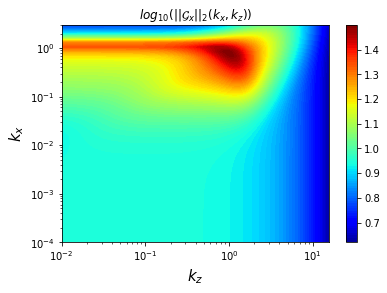

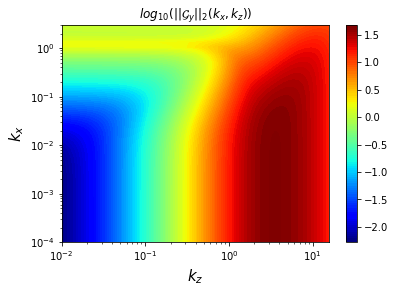

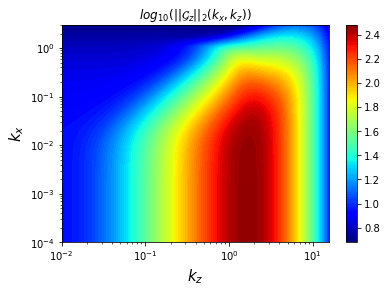

In [280]:
amplArr = np.sqrt(2.*GsKxKz2)
plt.contourf(bArr, aArr, np.log10(amplArr[:,:,0]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([0.6,1.5])
plt.colorbar(ticks=np.arange(0.7,1.41,0.1))
#plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{G}_{x}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig10p5a.eps',format='eps')
plt.show()

plt.contourf(bArr, aArr, np.log10(amplArr[:,:,1]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([-2.25,1.65])
plt.colorbar(ticks=np.arange(-2.,1.55,0.5))
#plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{G}_{y}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig10p5b.eps',format='eps')
plt.show()

plt.contourf(bArr, aArr, np.log10(amplArr[:,:,2]),100,cmap=plt.get_cmap('jet'))
plt.xscale("log"); plt.yscale("log")
plt.xlim([0.01,15.84])
plt.ylim([1.e-4, 3.02])
plt.clim([0.7,2.5])
plt.colorbar(ticks=np.arange(0.8,2.55,0.2))
#plt.colorbar()
plt.xlabel("$k_z$",fontsize=15)
plt.ylabel("$k_x$",fontsize=15)
plt.title("$log_{10}(||\mathcal{G}_{z}||_2 (k_x,k_z))$")
plt.savefig(figureFolder+'fig10p5c.eps',format='eps')
plt.show()



This is weird too.... I should multiply $G_s$ by 4 to account for all 4 modes, but ended up multiplying by just 2. 

## Fig. 10.7, 10.11, 10.13 Velocity contours for impulse response at $y \approx 0.68$

In [38]:
# Initialization
Re = 2000.       
# Grid
N = 60   # Wall-normal
aArr1 = np.concatenate(( np.linspace(0., 20., 129), np.linspace(-20., 0., 129)[1:-1]  ))
bArr1 = np.linspace(0., 30., 129)
tArr1 = np.array([5., 10., 15., 20.])

aArr2 = np.concatenate(( np.linspace(0., 5., 129), np.linspace(-5., 0., 129)[1:-1]  ))
bArr2 = np.linspace(0., 18., 129)
tArr2 = np.array([40., 80., 120., 160.])

y, DM = pseudo.chebdif(N,2)

# Impulse function
y0 = -0.9; eps = 1./2000.
fs = 1./(2.*np.sqrt(np.pi * eps )) * np.exp(-(y-y0)**2 / 4./eps )

# Impulse input to the velocity vorticity state (i.e., B*fs)
# Since there are 3 fs (and a total), I'll use Fs of size 4x2N
Fs = np.zeros((4, 2*N), dtype=np.complex)
Fsadj = Fs.copy()


D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]

Umat   = np.diag(1. - y**2)
dUmat  = np.diag(- 2.*y)
d2Umat  = -2.*np.identity(N)
I1 = np.identity(N); I2 = np.identity(2*N)
ZZ = np.zeros((N,N))
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']

if True:
    # Grids in physical space
    # Early times:
    zArr1 = np.linspace(-15., 15., 256)
    xArr1 = np.linspace(-5., 20., 256)
    Z1 = np.tile(zArr1.reshape((zArr1.size,1)), [1,xArr1.size])
    X1 = np.tile(xArr1.reshape((1,xArr1.size)), [zArr1.size,1])

    # Later times
    zArr2 = np.linspace(-25., 25., 256)
    xArr2 = np.linspace(0., 140., 256)
    Z2 = np.tile(zArr2.reshape((zArr2.size,1)), [1,xArr2.size])
    X2 = np.tile(xArr2.reshape((1,xArr2.size)), [zArr2.size,1])
    
    # I'll also record the full spectral flow field, just in case.
    uSpecArrFz1 = np.zeros(( tArr1.size, aArr1.size, bArr1.size, N), dtype=np.complex)

    # We'll record the velocity components at each time instance here.
    uFieldFz1 = np.zeros(( tArr1.size, zArr1.size, xArr1.size ))
    uFieldFz2 = np.zeros(( tArr2.size, zArr2.size, xArr2.size ))
    uFieldFy  = np.zeros(( tArr2.size, zArr2.size, xArr2.size ))
    uFieldFx  = np.zeros(( tArr2.size, zArr2.size, xArr2.size ))

    



def makeSystemTemp(a,b):
    # This time, we don't need the resolvent, but just the system matrices and their adjoints.
    Delta = D2 - (a**2 + b**2) * I1
    DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
    DeltaInv = np.linalg.solve(Delta, I1)

    LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
    LSQ = -1.j*a*Umat + Delta/Re
    Lco = -1.j*b*dUmat
    k2 = a**2 + b**2
    A = np.vstack(( 
            np.hstack(( DeltaInv @ LOS, ZZ )),
            np.hstack(( Lco           , LSQ)) ))
    LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
    Lcoadj = -1.j*b*DeltaInv @ dUmat
    LSQadj = 1.j*a*Umat + Delta/Re
    Aadj = np.vstack((
            np.hstack(( LOSadj, Lcoadj)),
            np.hstack(( ZZ    , LSQadj))  ))
    B = np.vstack((
            DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
            np.hstack((1.j*b*I1, ZZ, -1.j*a*I1))  ))
    C = (1./k2) * np.vstack((
            np.hstack((1.j*a*D1, -1.j*b*I1)),
            np.hstack((k2 * I1 , ZZ       )),
            np.hstack((1.j*b*D1,  1.j*a*I1)) ))
    Badj = C; Cadj = B

    Fs[0,:N] = -1.j*a*DeltaInv @ (D1@fs);  Fs[0,N:] = 1.j*b*fs
    Fs[1,:N] = -(a**2+b**2)*DeltaInv @ fs; Fs[1,N:] = 0.
    Fs[2,:N] = -1.j*b*DeltaInv @ (D1@fs);  Fs[2,N:] = -1.j*a*fs
    Fs[3] = Fs[0]+Fs[1]+Fs[2]

    Fsadj[0] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*a*D1@fs, -1.j*b*fs  ))
    Fsadj[1] = W2 @ np.concatenate(( fs, np.zeros(N,dtype=np.complex) ))
    Fsadj[2] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*b*D1@fs,  1.j*a*fs  ))
    Fsadj[3] = Fsadj[0] + Fsadj[1] + Fsadj[2]
    return A, C, Fs
    

ny = np.argwhere(y<0.7)[0][-1]
for i0 in range(tArr1.size):
    t = tArr1[i0]
    print("t=",t)
    for i1 in range(aArr1.size):
        a = aArr1[i1]
        if not i1%20: print("a=",a)
        for i2 in range(bArr1.size):
            b = bArr1[i2]
            if (b== 0. and a <= 0.): continue
            A, C, Fs = makeSystemTemp(a,b)

            # Response to impulse in spanwise
            velSpec = (C @ expm(t*A) @ Fs[2].reshape((2*N,1))).flatten()
            uRe = velSpec.real[ny]; uIm = velSpec.imag[ny]
            uFieldFz1[i0] += 2.*(  uRe * np.cos(a*X1 + b*Z1) - uIm * np.sin(a*X1 + b*Z1) )

for i0 in range(tArr2.size):
    t = tArr2[i0]
    print("t=",t)
    for i1 in range(aArr2.size):
        a = aArr2[i1]
        if not i1%20: print("a=",a)
        for i2 in range(bArr2.size):
            b = bArr2[i2]
            if (b== 0. and a <= 0.): continue
            A, C, Fs = makeSystemTemp(a,b)
            
            expFactor = C @ expm(t*A)
            
            # Response to impulse in spanwise
            velSpec = (   expFactor @ Fs[2].reshape((2*N,1))   ).flatten()
            uRe = velSpec.real[ny]; uIm = velSpec.imag[ny]
            uFieldFz2[i0] += 2.*(  uRe * np.cos(a*X2 + b*Z2) - uIm * np.sin(a*X2 + b*Z2) )
            
            # Response to impulse in wall-normal
            velSpec = (   expFactor @ Fs[1].reshape((2*N,1))   ).flatten()
            uRe = velSpec.real[ny]; uIm = velSpec.imag[ny]
            uFieldFy[i0] += 2.*(  uRe * np.cos(a*X2 + b*Z2) - uIm * np.sin(a*X2 + b*Z2) )
            
            # Response to impulse in streamwise
            velSpec = (   expFactor @ Fs[0].reshape((2*N,1))   ).flatten()
            uRe = velSpec.real[ny]; uIm = velSpec.imag[ny]
            uFieldFx[i0] += 2.*(  uRe * np.cos(a*X2 + b*Z2) - uIm * np.sin(a*X2 + b*Z2) )
            


            
            
            

t= 5.0
a= 0.0
a= 3.125
a= 6.25
a= 9.375
a= 12.5
a= 15.625
a= 18.75
a= -18.125
a= -15.0
a= -11.875
a= -8.75
a= -5.625
a= -2.5
t= 10.0
a= 0.0
a= 3.125
a= 6.25
a= 9.375
a= 12.5
a= 15.625
a= 18.75
a= -18.125
a= -15.0
a= -11.875
a= -8.75
a= -5.625
a= -2.5
t= 15.0
a= 0.0
a= 3.125
a= 6.25
a= 9.375
a= 12.5
a= 15.625
a= 18.75
a= -18.125
a= -15.0
a= -11.875
a= -8.75
a= -5.625
a= -2.5
t= 20.0
a= 0.0
a= 3.125
a= 6.25
a= 9.375
a= 12.5
a= 15.625
a= 18.75
a= -18.125
a= -15.0
a= -11.875
a= -8.75
a= -5.625
a= -2.5
t= 40.0
a= 0.0
a= 0.78125
a= 1.5625
a= 2.34375
a= 3.125
a= 3.90625
a= 4.6875
a= -4.53125
a= -3.75
a= -2.96875
a= -2.1875
a= -1.40625
a= -0.625
t= 80.0
a= 0.0
a= 0.78125
a= 1.5625
a= 2.34375
a= 3.125
a= 3.90625
a= 4.6875
a= -4.53125
a= -3.75
a= -2.96875
a= -2.1875
a= -1.40625
a= -0.625
t= 120.0
a= 0.0
a= 0.78125
a= 1.5625
a= 2.34375
a= 3.125
a= 3.90625
a= 4.6875
a= -4.53125
a= -3.75
a= -2.96875
a= -2.1875
a= -1.40625
a= -0.625
t= 160.0
a= 0.0
a= 0.78125
a= 1.5625
a= 2.34375
a= 3.125
a= 3.90625

In [100]:
if False:
    uFieldFz10 = uFieldFz1.copy()
    uFieldFz20 = uFieldFz2.copy()
    uFieldFy0 = uFieldFy.copy()
    uFieldFx0 = uFieldFx.copy()

fac1 = (1./(2.*np.pi)**2     ) * (aArr1[1] * bArr1[1] )** 1
fac2 = (1./(2.*np.pi)**2     ) * (aArr2[1] * bArr2[1] )** 1
uFieldFz1 = uFieldFz10 * fac1
uFieldFz2 = uFieldFz20 * fac2
uFieldFy = uFieldFy0 * fac2
uFieldFx = uFieldFx0 * fac2


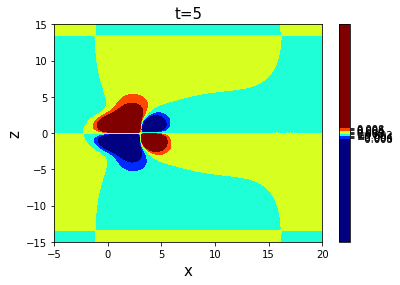

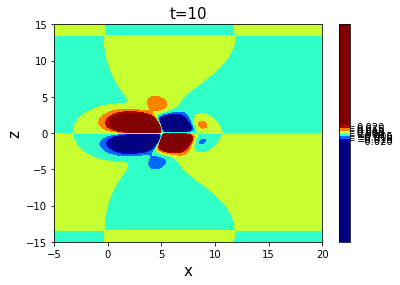

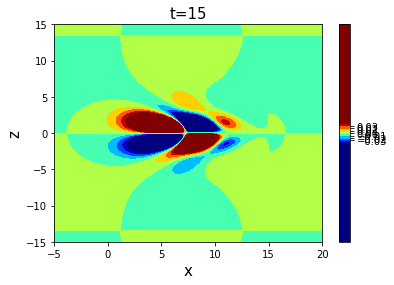

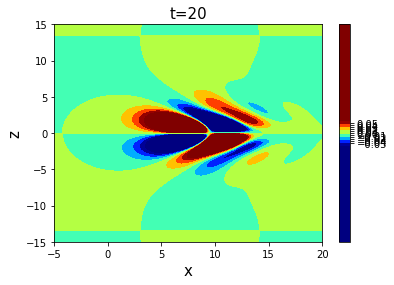

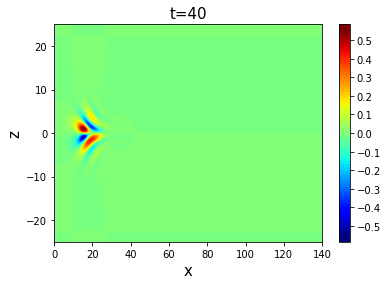

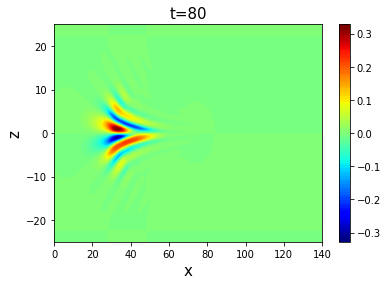

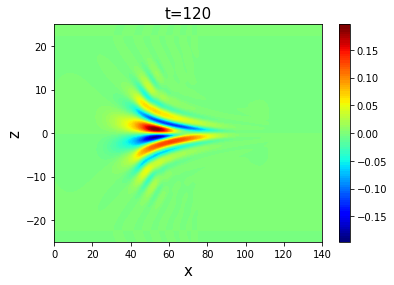

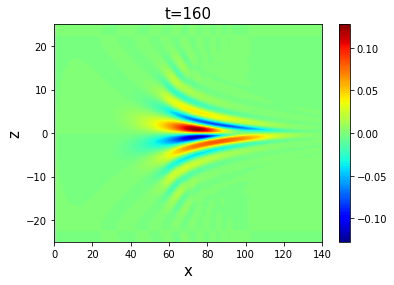

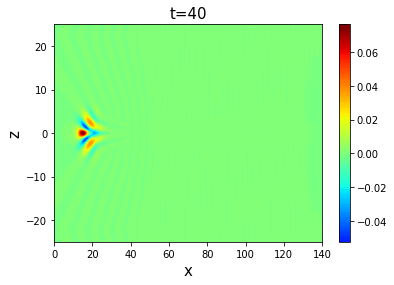

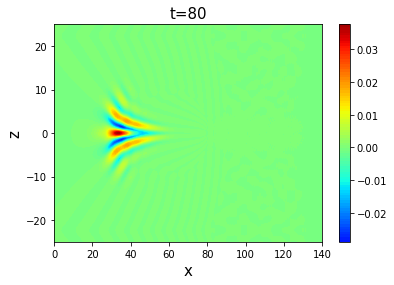

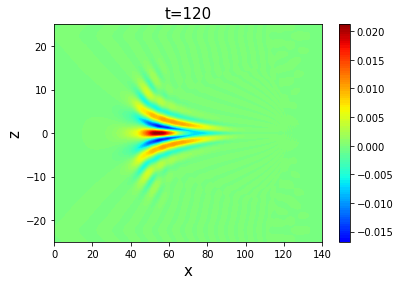

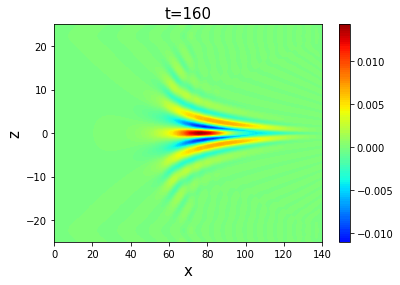

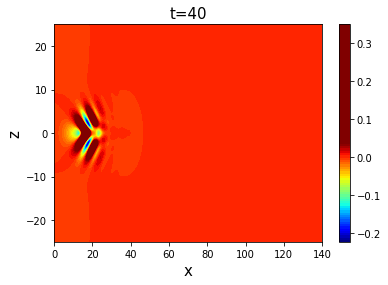

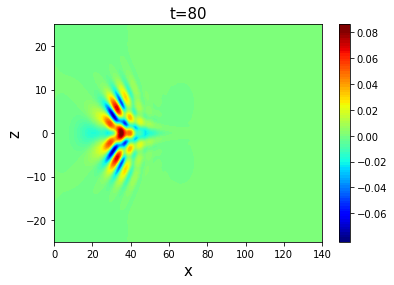

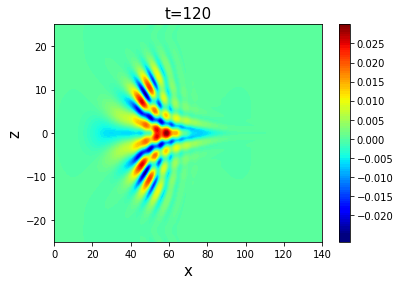

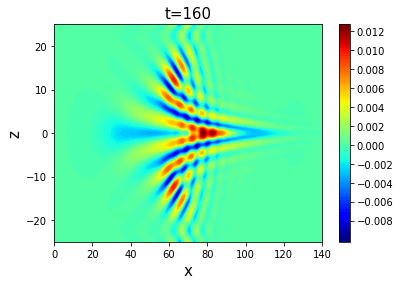

In [102]:
def plotFunTemp(X,Z,fArr, t, fName, cl1,cl2,tk1,tk2,tkInt,xLim=None,yLim=None):
    #plt.contourf(X,Z,fArr,100, cmap="jet")
    plt.contourf(X,Z,fArr,100, cmap="jet")
    plt.clim([cl1,cl2])
    plt.colorbar(ticks=np.arange(tk1,1.01*tk2,tkInt))
    plt.xlabel("x", fontsize=15); plt.ylabel("z", fontsize=15)
    plt.title("t=%d"%t,fontsize=15)
    if xLim is not None: plt.xlim(xLim)
    if yLim is not None: plt.ylim(yLim)
    plt.savefig(figureFolder+fName,format='eps')
    plt.show()
    return


# Impulse in z
clArr = [ 0.009, 0.022, 0.04, 0.055, 0.55, 0.32, 0.19, 0.13 ]
tkArr = [ 0.008, 0.02, 0.03, 0.05, 0.5, 0.3, 0.15, 0.1]
tkIntArr=[ 0.002, 0.005, 0.01, 0.01, 0.1, 0.1, 0.05, 0.05]
figInd = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
tArr = np.concatenate(( tArr1, tArr2 ))

for ind in range(4):
    plotFunTemp( X1,Z1,uFieldFz1[ind], tArr[ind], 'tmpFig10p7%s.eps'%figInd[ind], 
           -clArr[ind], clArr[ind], -tkArr[ind], tkArr[ind], tkIntArr[ind])

for ind in range(4):
    plotFunTemp( X2,Z2,uFieldFz2[ind], tArr[ind+4], 'tmpFig10p7%s.eps'%figInd[ind+4], 
           -clArr[ind+4], clArr[ind+4], -tkArr[ind+4], tkArr[ind+4], tkIntArr[ind+4] )


# Impulse in y
clArr = [ 0.075, 0.04, 0.022, 0.015 ]
tkArr = [ 0.06, 0.03, 0.02, 0.01]
tkIntArr=[ 0.02, 0.01, 0.005, 0.005]
figInd = ['a', 'b', 'c', 'd']
tArr =  tArr2.copy()

for ind in range(4):
    plotFunTemp( X2, Z2, uFieldFy[ind], tArr[ind], 'tmpFig10p11%s.eps'%figInd[ind], 
               -clArr[ind], clArr[ind], -tkArr[ind], tkArr[ind], tkIntArr[ind] )

    
# Impulse in x
cl1Arr = [ -0.22, -0.08, -0.025, -0.01 ]
cl2Arr = [ 0.037, 0.082, 0.03, 0.0125 ]
tk1Arr = [ -0.2, -0.06, -0.02, -0.008 ]
tk2Arr = [ 0.3, 0.08, 0.025, 0.012]
tkIntArr = [ 0.1, 0.02, 0.005, 0.002]
figInd = ['a', 'b', 'c', 'd']
tArr = tArr2.copy()

for ind in range(4):
    plotFunTemp( X2, Z2, uFieldFx[ind], tArr[ind], 'tmpFig10p13%s.eps'%figInd[ind], 
               cl1Arr[ind], cl2Arr[ind], tk1Arr[ind], tk2Arr[ind], tkIntArr[ind] )
    


In [ ]:
plt.contourf(X1, Z1, uFieldFz1[0],100, cmap="jet")
plt.colorbar(); plt.show()

plt.contourf(X1, Z1, uFieldFz1[1],100, cmap="jet")
plt.colorbar(); plt.show()

plt.contourf(X1, Z1, uFieldFz1[2],100, cmap="jet")
plt.colorbar(); plt.show()

plt.contourf(X1, Z1, uFieldFz1[3],100, cmap="jet")
plt.colorbar(); plt.show()


# Impulse response for turbulent mean

In [110]:
# Initialization
Re = 2000.       # This is ReTau, not Re_CL
# Grid
N = 251   # Wall-normal

# I'm using the same resolution as laminar. Will do a grid independence check later. 
aArr1 = np.concatenate(( np.linspace(0., 20., 129), np.linspace(-20., 0., 129)[1:-1]  ))
bArr1 = np.linspace(0., 30., 129)
tArr1 = np.array([1., 2., 5., 7.])

aArr2 = np.concatenate(( np.linspace(0., 5., 129), np.linspace(-5., 0., 129)[1:-1]  ))
bArr2 = np.linspace(0., 18., 129)
tArr2 = np.array([10., 15., 20., 30.])

y, DM = pseudo.chebdif(N,2)

# Impulse function
y0 = -0.9; eps = 1./2000.
fs = 1./(2.*np.sqrt(np.pi * eps )) * np.exp(-(y-y0)**2 / 4./eps )

# Impulse input to the velocity vorticity state (i.e., B*fs)
# Since there are 3 fs (and a total), I'll use Fs of size 4x2N
Fs = np.zeros((4, 2*N), dtype=np.complex)
Fsadj = Fs.copy()


D4 = pseudo.cheb4c(N)
D1 = DM[:,:,0]; D2 = DM[:,:,1]


turbDict = ops.turbMeanChannel(N=N, Re=Re)
Umat   = np.diag(turbDict['U'])
dUmat  = np.diag(turbDict['dU'])
d2Umat  = np.diag(turbDict['d2U'])
I1 = np.identity(N); I2 = np.identity(2*N)
ZZ = np.zeros((N,N))
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si= weightDict['W3SqrtInv']
W2s = weightDict['W2Sqrt']
W2si= weightDict['W2SqrtInv']
W2  = weightDict['W2']

if True:
    # Grids in physical space
    # Early times:
    zArr1 = np.linspace(-15., 15., 256)
    xArr1 = np.linspace(-5., 20., 256)
    Z1 = np.tile(zArr1.reshape((zArr1.size,1)), [1,xArr1.size])
    X1 = np.tile(xArr1.reshape((1,xArr1.size)), [zArr1.size,1])

    # Later times
    zArr2 = np.linspace(-25., 25., 256)
    xArr2 = np.linspace(0., 140., 256)
    Z2 = np.tile(zArr2.reshape((zArr2.size,1)), [1,xArr2.size])
    X2 = np.tile(xArr2.reshape((1,xArr2.size)), [zArr2.size,1])
    
    # I'll also record the full spectral flow field, just in case.
    uSpecArrFz1 = np.zeros(( tArr1.size, aArr1.size, bArr1.size, N), dtype=np.complex)

    # We'll record the velocity components at each time instance here.
    uFieldFz1 = np.zeros(( tArr1.size, zArr1.size, xArr1.size ))
    uFieldFz2 = np.zeros(( tArr2.size, zArr2.size, xArr2.size ))
    uFieldFy  = np.zeros(( tArr2.size, zArr2.size, xArr2.size ))
    uFieldFx  = np.zeros(( tArr2.size, zArr2.size, xArr2.size ))

    



def makeSystemTemp(a,b):
    # This time, we don't need the resolvent, but just the system matrices and their adjoints.
    Delta = D2 - (a**2 + b**2) * I1
    DeltaSq = D4 + ((a**2 + b**2)**2) * I1 - 2.*(a**2+b**2)*D2
    DeltaInv = np.linalg.solve(Delta, I1)

    LOS = -1.j*a* Umat @ Delta + 1.j*a* d2Umat + DeltaSq/Re
    LSQ = -1.j*a*Umat + Delta/Re
    Lco = -1.j*b*dUmat
    k2 = a**2 + b**2
    A = np.vstack(( 
            np.hstack(( DeltaInv @ LOS, ZZ )),
            np.hstack(( Lco           , LSQ)) ))
    LOSadj = 1.j*a*Umat - 1.j*a*DeltaInv @ d2Umat + (DeltaInv @ DeltaSq)/Re
    Lcoadj = -1.j*b*DeltaInv @ dUmat
    LSQadj = 1.j*a*Umat + Delta/Re
    Aadj = np.vstack((
            np.hstack(( LOSadj, Lcoadj)),
            np.hstack(( ZZ    , LSQadj))  ))
    B = np.vstack((
            DeltaInv@ np.hstack(( -1.j*a*D1, -k2*I1, -1.j*b*D1 )),
            np.hstack((1.j*b*I1, ZZ, -1.j*a*I1))  ))
    C = (1./k2) * np.vstack((
            np.hstack((1.j*a*D1, -1.j*b*I1)),
            np.hstack((k2 * I1 , ZZ       )),
            np.hstack((1.j*b*D1,  1.j*a*I1)) ))
    Badj = C; Cadj = B

    Fs[0,:N] = -1.j*a*DeltaInv @ (D1@fs);  Fs[0,N:] = 1.j*b*fs
    Fs[1,:N] = -(a**2+b**2)*DeltaInv @ fs; Fs[1,N:] = 0.
    Fs[2,:N] = -1.j*b*DeltaInv @ (D1@fs);  Fs[2,N:] = -1.j*a*fs
    Fs[3] = Fs[0]+Fs[1]+Fs[2]

    Fsadj[0] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*a*D1@fs, -1.j*b*fs  ))
    Fsadj[1] = W2 @ np.concatenate(( fs, np.zeros(N,dtype=np.complex) ))
    Fsadj[2] = 1./(a**2+b**2) * W2 @ np.concatenate(( -1.j*b*D1@fs,  1.j*a*fs  ))
    Fsadj[3] = Fsadj[0] + Fsadj[1] + Fsadj[2]
    return A, C, Fs
    

ny = np.argwhere(y<0.7)[0][-1]
for i0 in range(tArr1.size):
    t = tArr1[i0]
    print("t=",t)
    for i1 in range(aArr1.size):
        a = aArr1[i1]
        if not i1%20: print("a=",a)
        for i2 in range(bArr1.size):
            b = bArr1[i2]
            if (b== 0. and a <= 0.): continue
            A, C, Fs = makeSystemTemp(a,b)

            # Response to impulse in spanwise
            velSpec = (C @ expm(t*A) @ Fs[2].reshape((2*N,1))).flatten()
            uRe = velSpec.real[ny]; uIm = velSpec.imag[ny]
            uFieldFz1[i0] += 2.*(  uRe * np.cos(a*X1 + b*Z1) - uIm * np.sin(a*X1 + b*Z1) )

for i0 in range(tArr2.size):
    t = tArr2[i0]
    print("t=",t)
    for i1 in range(aArr2.size):
        a = aArr2[i1]
        if not i1%20: print("a=",a)
        for i2 in range(bArr2.size):
            b = bArr2[i2]
            if (b== 0. and a <= 0.): continue
            A, C, Fs = makeSystemTemp(a,b)
            
            expFactor = C @ expm(t*A)
            
            # Response to impulse in spanwise
            velSpec = (   expFactor @ Fs[2].reshape((2*N,1))   ).flatten()
            uRe = velSpec.real[ny]; uIm = velSpec.imag[ny]
            uFieldFz2[i0] += 2.*(  uRe * np.cos(a*X2 + b*Z2) - uIm * np.sin(a*X2 + b*Z2) )
            
            # Response to impulse in wall-normal
            velSpec = (   expFactor @ Fs[1].reshape((2*N,1))   ).flatten()
            uRe = velSpec.real[ny]; uIm = velSpec.imag[ny]
            uFieldFy[i0] += 2.*(  uRe * np.cos(a*X2 + b*Z2) - uIm * np.sin(a*X2 + b*Z2) )
            
            # Response to impulse in streamwise
            velSpec = (   expFactor @ Fs[0].reshape((2*N,1))   ).flatten()
            uRe = velSpec.real[ny]; uIm = velSpec.imag[ny]
            uFieldFx[i0] += 2.*(  uRe * np.cos(a*X2 + b*Z2) - uIm * np.sin(a*X2 + b*Z2) )
            
            
            
            

Using parameters Re=2000, alfa=25.4, kapa=0.426, N=251
t= 1.0
a= 0.0


KeyboardInterrupt: 

In [105]:
if False:
    uFieldFz10Turb = uFieldFz1.copy()
    uFieldFz20Turb = uFieldFz2.copy()
    uFieldFy0Turb = uFieldFy.copy()
    uFieldFx0Turb = uFieldFx.copy()

fac1 = (1./(2.*np.pi)**2     ) * (aArr1[1] * bArr1[1] )** 1
fac2 = (1./(2.*np.pi)**2     ) * (aArr2[1] * bArr2[1] )** 1
uFieldFz1 = uFieldFz10Turb * fac1
uFieldFz2 = uFieldFz20Turb * fac2
uFieldFy = uFieldFy0Turb * fac2
uFieldFx = uFieldFx0Turb * fac2


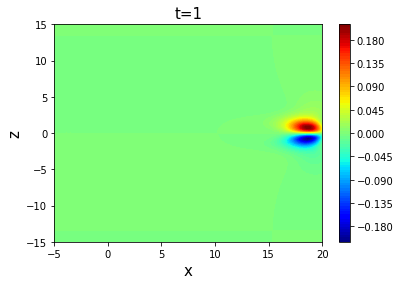

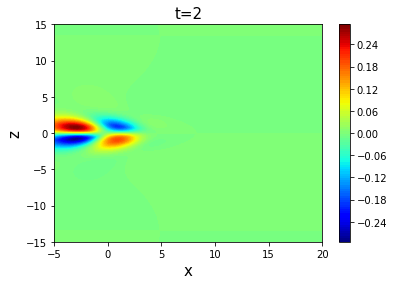

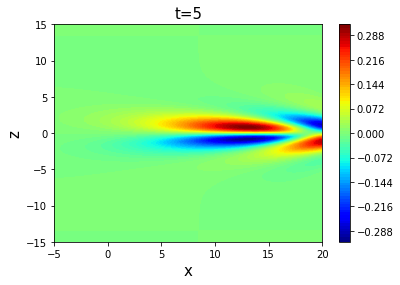

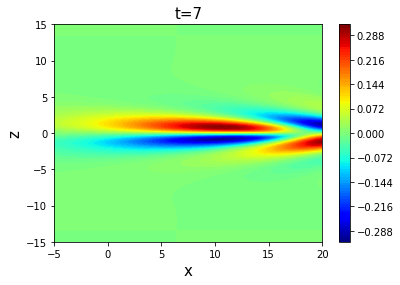

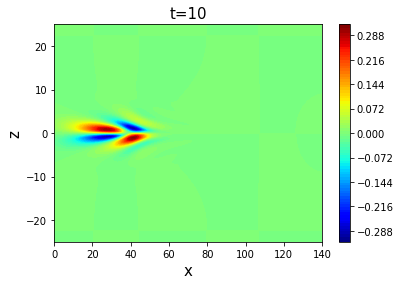

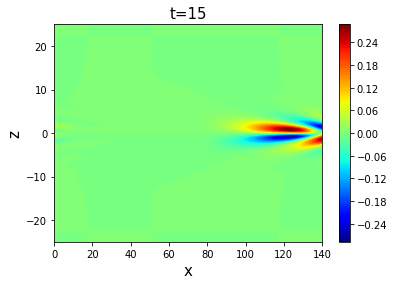

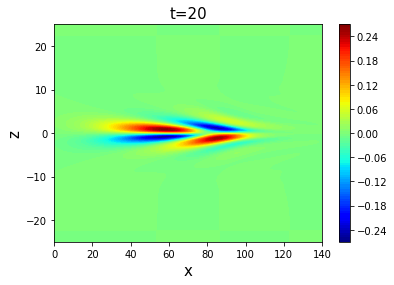

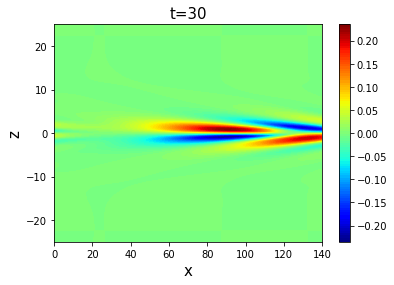

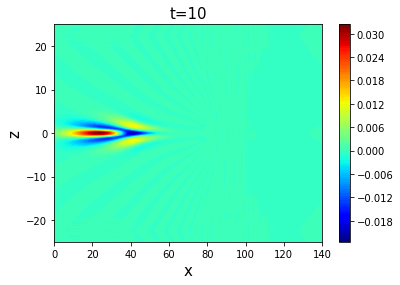

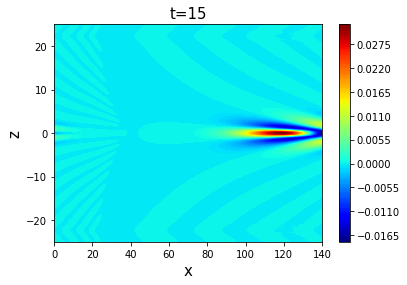

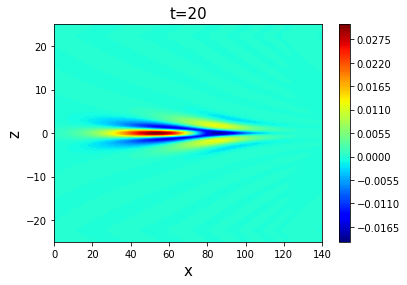

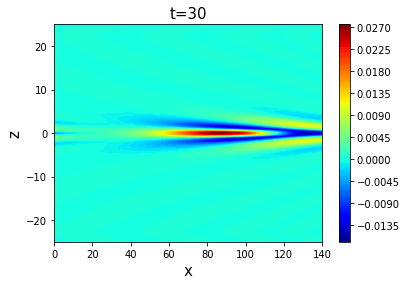

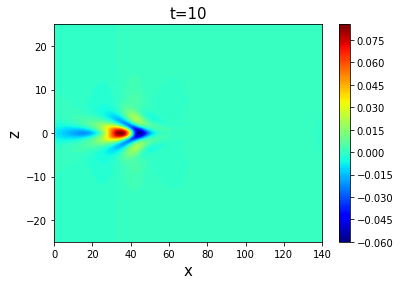

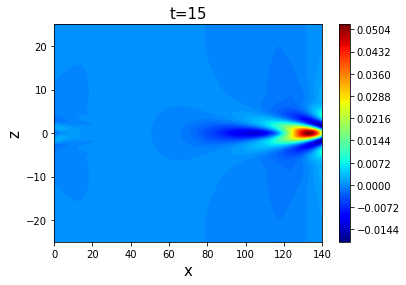

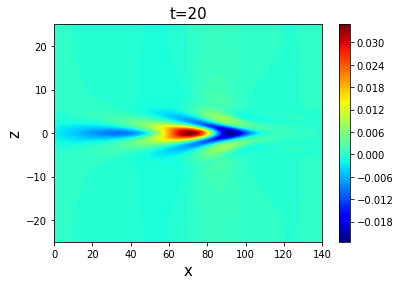

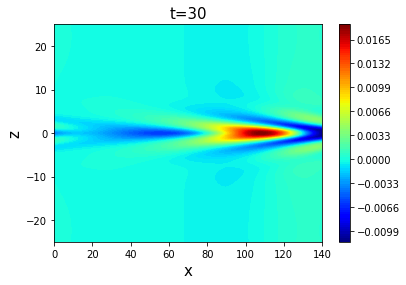

In [108]:
#def plotFunTemp(X,Z,fArr, t, fName, cl1,cl2,tk1,tk2,tkInt,xLim=None,yLim=None):
def plotFunTemp(X,Z,fArr,t):
    #plt.contourf(X,Z,fArr,100, cmap="jet")
    plt.contourf(X,Z,fArr,100, cmap="jet")
    #plt.clim([cl1,cl2])
    #plt.colorbar(ticks=np.arange(tk1,1.01*tk2,tkInt))
    plt.colorbar()
    plt.xlabel("x", fontsize=15); plt.ylabel("z", fontsize=15)
    plt.title("t=%d"%t,fontsize=15)
    #if xLim is not None: plt.xlim(xLim)
    #if yLim is not None: plt.ylim(yLim)
    #plt.savefig(figureFolder+fName,format='eps')
    plt.show()
    return


tArr = tArr1.copy()
for ind in range(4):
    plotFunTemp( X1,Z1,uFieldFz1[ind], tArr[ind])

tArr = tArr2.copy()
for ind in range(4):
    plotFunTemp( X2,Z2,uFieldFz2[ind], tArr[ind])


for ind in range(4):
    plotFunTemp( X2, Z2, uFieldFy[ind], tArr[ind])

    

for ind in range(4):
    plotFunTemp( X2, Z2, uFieldFx[ind], tArr[ind])
    


In [36]:
-15. % 5.

0.0

# Saving impulse response fields

In [46]:
N = 41; Re = 2000.
na = 512; nb = 128
aMax =5.; bMax = 18.

saveFolder = '/kepler/sabarish/impulseResponse/jovanovic/'
# Splitting aArr into 32 pieces
aArrLong = np.linspace(0, aMax, na//2+1)
aArrLong = np.concatenate( (aArrLong, -aArrLong[-2:0:-1]) )
aArrLong = aArrLong.reshape((32,na//32))
bArr = np.linspace(0., bMax, nb+1)
flowDict = {'Re':Re, 'flowState':'lam', 'flowClass':'channel','eddy':False}
tArr = np.array([40., 80., 120., 160.])

fPrefix0 = saveFolder+'ffLamFullKx_aPart'
for inda in range(16, aArrLong.shape[0]):
    aArr = aArrLong[inda]
    fPrefix = fPrefix0+"%d_%d"%(inda+1,aArrLong.shape[0])
    
    respDict = flowField.impulseResponse(aArr, bArr, N, tArr, 
                                         flowDict=flowDict, fPrefix=fPrefix)
    


/home/svadarevu/gitwork/linear/library/flowField.py:79: UserWarning: Need to write some check for wall-normal grid independence
  warn("Need to write some check for wall-normal grid independence")
/home/svadarevu/gitwork/linear/library/ops.py:135: UserWarning: Initialized instance of 'linearize', version 10.1.1.
New in this version: All system matrices are defined in makeSystem('eddy'=False,'adjoint'=False)
Eddy viscosity enhancement is allowed, but baseflow is reset to turbulent according to turbMeanChannel()
matNorm() defined to compute 2-norm and HS norm directly from unweighted matrices
weightDict is added as a class attribute
  "weightDict is added as a class attribute")
/home/svadarevu/gitwork/linear/library/flowField.py:293: UserWarning: flowField.py (V10.6);
'symm' dropped because I got it wrong. Modes now go positive and negative in kx.
  "'symm' dropped because I got it wrong. Modes now go positive and negative in kx.")
/home/svadarevu/gitwork/linear/library/impulseResponse.p

Computing impulse response at tArr, aArr, bArr: [  40.   80.  120.  160.] [ 5.         -4.98046875 -4.9609375  -4.94140625 -4.921875   -4.90234375
 -4.8828125  -4.86328125 -4.84375    -4.82421875 -4.8046875  -4.78515625
 -4.765625   -4.74609375 -4.7265625  -4.70703125] [  0.         0.140625   0.28125    0.421875   0.5625     0.703125
   0.84375    0.984375   1.125      1.265625   1.40625    1.546875   1.6875
   1.828125   1.96875    2.109375   2.25       2.390625   2.53125
   2.671875   2.8125     2.953125   3.09375    3.234375   3.375      3.515625
   3.65625    3.796875   3.9375     4.078125   4.21875    4.359375   4.5
   4.640625   4.78125    4.921875   5.0625     5.203125   5.34375
   5.484375   5.625      5.765625   5.90625    6.046875   6.1875     6.328125
   6.46875    6.609375   6.75       6.890625   7.03125    7.171875   7.3125
   7.453125   7.59375    7.734375   7.875      8.015625   8.15625
   8.296875   8.4375     8.578125   8.71875    8.859375   9.         9.140625
   9.2

In [102]:
t = 120.
fNameList = [(saveFolder+'ffLamFullKx_aPart%d_32_Fz_t%05d.mat'%(k,100*t)) for k in range(1,33)]
ff0 = flowField.loadff(fNameList[0])
#print(ff0.shape)
#print(ff0.aArr)
for fName in fNameList[1:]:
    ff0 = ff0.appendField(flowField.loadff(fName))
    #print(ff0.aArr)

fNameList = [(saveFolder+'ffLam_aPart%d_32_Fz_t%05d.mat'%(k,100*t)) for k in range(1,33)]
ff1 = flowField.loadff(fNameList[0])
#print(ff0.shape)
for fName in fNameList[1:]:
    ff1 = ff1.appendField(flowField.loadff(fName))

#ff0[ff0.aArr.size//2+1:] = 0.
ff0.savePhysical(padded=False)

/home/svadarevu/gitwork/linear/library/flowField.py:299: UserWarning: flowField.py (V10.6);
'symm' dropped because I got it wrong. Modes now go positive and negative in kx.
  
/home/svadarevu/gitwork/linear/library/flowField.py:702: UserWarning: I'm not checking for coinciding aArr; ensure it doesn't happen.
  ffLong[i0,i1] = self[i0,i1self]
/home/svadarevu/gitwork/linear/library/flowField.py:703: UserWarning: Ensure fields are appended in kx as 0,1,..,L,-L+1,..,-1
  i1self += 1
/home/svadarevu/gitwork/linear/library/flowField.py:704: UserWarning: VERY IMPORTANT: ORDERING OF kx in .appendField() is extremely important
  elif b in ff.bArr:


Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLamFullKx_aPart1_32_Fz_t12000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLamFullKx_aPart2_32_Fz_t12000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLamFullKx_aPart3_32_Fz_t12000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLamFullKx_aPart4_32_Fz_t12000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLamFullKx_aPart5_32_Fz_t12000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLamFullKx_aPart6_32_Fz_t12000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLamFullKx_aPart7_32_Fz_t12000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLamFullKx_aPart8_32_Fz_t12000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLamFullKx_aPart9_32_Fz_t12000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLamFullKx_aPar

/home/svadarevu/gitwork/linear/library/flowField.py:476: UserWarning: Remember to have both positive and negative streamwise wavenumbers, and non-negative spanwise.
  # x-Modes go 0,1,..,L-1,L,-L+1,-L+2,..,-1, a total of 2*L
/home/svadarevu/gitwork/linear/library/flowField.py:734: UserWarning: Assuming that modes go positive and negative in kx
  return ffLong


Saved fields   ['u']   to file testPhysFields.mat


In [95]:
ff0[1,1,0] - ff1[0,0,0], ff0.aArr[1], ff0.bArr[1], ff1.aArr[0], ff1.bArr[0]

(flowField([ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]),
 0.01953125,
 0.140625,
 0.01953125,
 0.140625)

/home/svadarevu/gitwork/linear/library/flowField.py:476: UserWarning: Remember to have both positive and negative streamwise wavenumbers, and non-negative spanwise.
  # x-Modes go 0,1,..,L-1,L,-L+1,-L+2,..,-1, a total of 2*L
/home/svadarevu/gitwork/linear/library/flowField.py:734: UserWarning: Assuming that modes go positive and negative in kx
  return ffLong


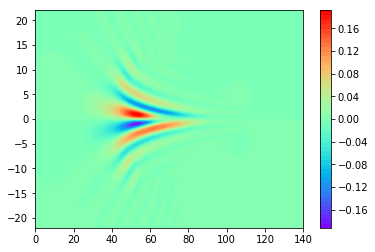

In [101]:
if False:
    uDict0 = loadmat('testPhysFields.mat')
    u0 = uDict0['u']
    plt.contourf(xArr, zArr, u[:,:,10].T, 50, cmap='rainbow')
    plt.colorbar()
    plt.xlim([0., 140.])
    plt.ylim([-22., 22.])
    plt.show()

uDict1 = ff0.toPhysical(arr=ff0[:,:,0],padded=False)
xArr = uDict1['xArr'].flatten(); zArr = uDict1['zArr'].flatten()
u1 = uDict1['arrPhys']
#u1 = flowField._spec2physIfft(ff0[:,:,0])
plt.contourf(xArr, zArr, u1[:,:,10].T, 50, cmap='rainbow')
plt.colorbar()
plt.xlim([0., 140.])
plt.ylim([-22., 22.])
plt.show()


In [71]:
ff0.aArr

array([ 0.        ,  0.01953125,  0.0390625 ,  0.05859375,  0.078125  ,
        0.09765625,  0.1171875 ,  0.13671875,  0.15625   ,  0.17578125,
        0.1953125 ,  0.21484375,  0.234375  ,  0.25390625,  0.2734375 ,
        0.29296875,  0.3125    ,  0.33203125,  0.3515625 ,  0.37109375,
        0.390625  ,  0.41015625,  0.4296875 ,  0.44921875,  0.46875   ,
        0.48828125,  0.5078125 ,  0.52734375,  0.546875  ,  0.56640625,
        0.5859375 ,  0.60546875,  0.625     ,  0.64453125,  0.6640625 ,
        0.68359375,  0.703125  ,  0.72265625,  0.7421875 ,  0.76171875,
        0.78125   ,  0.80078125,  0.8203125 ,  0.83984375,  0.859375  ,
        0.87890625,  0.8984375 ,  0.91796875,  0.9375    ,  0.95703125,
        0.9765625 ,  0.99609375,  1.015625  ,  1.03515625,  1.0546875 ,
        1.07421875,  1.09375   ,  1.11328125,  1.1328125 ,  1.15234375,
        1.171875  ,  1.19140625,  1.2109375 ,  1.23046875,  1.25      ,
        1.26953125,  1.2890625 ,  1.30859375,  1.328125  ,  1.34

In [10]:
for t in np.array([5., 10., 15., 20.]):
    fNameList = [(saveFolder+'ffLam_aPart%d_32_Fz_t%05d.mat'%(k,100*t)) for k in range(1,2)]
    ff0 = flowField.loadff(fNameList[0])
    #print(ff0.shape)
    for fName in fNameList[1:]:
        ff0 = ff0.appendField(flowField.loadff(fName))
    print(ff0.shape)
    
    testArr = ff0[:2, :2].view(np.ndarray).copy()
    ff0[:] = 0.
    ff0[:2, :2] = testArr
    
    %prun -s cumulative swirlDict = ff0.swirl(fName=saveFolder+'lamPhysFinal_test_Fz_t%05d.mat'%(100.*t), uField=True, vorzField=True,padded=True)


/home/svadarevu/gitwork/linear/library/flowField.py:294: UserWarning: flowField.py (V10.2);
Need to clean up old get Physical functions.
Need to integrate swirl() with toPhysical().
Think about using fft when creating physical fields.
  "Think about using fft when creating physical fields.")


Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLam_aPart1_32_Fz_t00500.mat
(4, 128, 3, 41)
 Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLam_aPart1_32_Fz_t01000.mat
(4, 128, 3, 41)


/home/svadarevu/gitwork/linear/library/flowField.py:294: UserWarning: flowField.py (V10.2);
Need to clean up old get Physical functions.
Need to integrate swirl() with toPhysical().
Think about using fft when creating physical fields.
  "Think about using fft when creating physical fields.")


 Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLam_aPart1_32_Fz_t01500.mat
(4, 128, 3, 41)


/home/svadarevu/gitwork/linear/library/flowField.py:294: UserWarning: flowField.py (V10.2);
Need to clean up old get Physical functions.
Need to integrate swirl() with toPhysical().
Think about using fft when creating physical fields.
  "Think about using fft when creating physical fields.")


 Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLam_aPart1_32_Fz_t02000.mat
(4, 128, 3, 41)


/home/svadarevu/gitwork/linear/library/flowField.py:294: UserWarning: flowField.py (V10.2);
Need to clean up old get Physical functions.
Need to integrate swirl() with toPhysical().
Think about using fft when creating physical fields.
  "Think about using fft when creating physical fields.")


In [32]:
t = 20.
fNameList = [(saveFolder+'ffLam_aPart%d_32_Fz_t%05d.mat'%(k,100*t)) for k in range(1,33)]
ff0 = flowField.loadff(fNameList[0])
#print(ff0.shape)
for fName in fNameList[1:]:
    ff0 = ff0.appendField(flowField.loadff(fName))
swirlDict = ff0.swirl(fName=saveFolder+'lamPhysFinal_test_Fz_t%05d.mat'%(100.*t), uField=True, vorzField=True,padded=False, ySpace='cheb')
uPhys = swirlDict['uPhys']
vorzPhys = swirlDict['vorzPhys']
swirlPhys = swirlDict['swirl']
xArr = swirlDict['xArr']; zArr = swirlDict['zArr']



/home/svadarevu/gitwork/linear/library/flowField.py:294: UserWarning: flowField.py (V10.2);
Need to clean up old get Physical functions.
Need to integrate swirl() with toPhysical().
Think about using fft when creating physical fields.
  "Think about using fft when creating physical fields.")
/home/svadarevu/gitwork/linear/library/flowField.py:755: UserWarning: I'm not checking for coinciding aArr; ensure it doesn't happen.
  a = aNew[i0]


Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLam_aPart1_32_Fz_t02000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLam_aPart2_32_Fz_t02000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLam_aPart3_32_Fz_t02000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLam_aPart4_32_Fz_t02000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLam_aPart5_32_Fz_t02000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLam_aPart6_32_Fz_t02000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLam_aPart7_32_Fz_t02000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLam_aPart8_32_Fz_t02000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLam_aPart9_32_Fz_t02000.mat
Loaded flowField from  /kepler/sabarish/impulseResponse/jovanovic/ffLam_aPart10_32_Fz_t02000.mat
Loaded flowField from  /kepler/sabarish

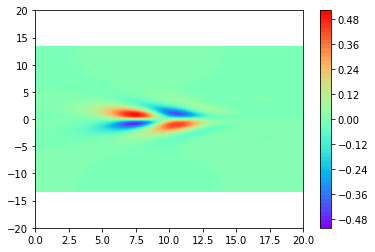

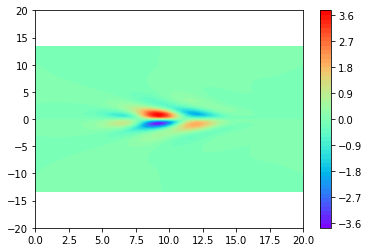

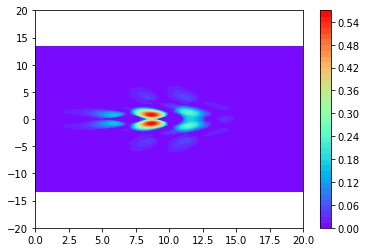

In [33]:
plt.contourf(xArr, zArr, uPhys[:,:,10].T, 50, cmap='rainbow')
#plt.xlim([0., 140.]); plt.ylim([-22., 22.])
plt.xlim([0., 20.]); plt.ylim([-20., 20.])
plt.colorbar()
plt.show()

plt.contourf(xArr, zArr, vorzPhys[:,:,10].T, 50, cmap='rainbow')
#plt.xlim([0., 140.]); plt.ylim([-22., 22.])
plt.xlim([0., 20.]); plt.ylim([-20., 20.])
plt.colorbar()
plt.show()

plt.contourf(xArr, zArr, swirlPhys[:,:,10].T, 50, cmap='rainbow')
#plt.xlim([0., 140.]); plt.ylim([-22., 22.])
plt.xlim([0., 20.]); plt.ylim([-20., 20.])
plt.colorbar()
plt.show()

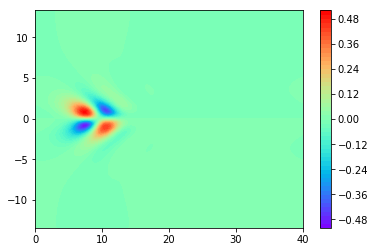

In [34]:
uNew = ff0.toPhysical(ff0[:,:,0],  symm='odd',ySpace='cheb')['arrPhys']
plt.contourf(xArr, zArr, uNew[:,:,10].T, 50, cmap='rainbow')
#plt.xlim([0., 140.]); plt.ylim([-22., 22.])
plt.colorbar()
plt.show()